In [ ]:
!pip install mlflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import glob
import pickle
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
import pandas as pd

# Chemins vers les fichiers CSV
files = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv"
}

# Lire les fichiers CSV
data_frames = {}
for name, path in files.items():
    try:
        data_frames[name] = pd.read_csv(path)
    except pd.errors.ParserError as e:
        print(f"Error reading {name}: {e}")
        # Try reading with a different delimiter (e.g., tab)
        try:
            data_frames[name] = pd.read_csv(path, sep='\t')
            print(f"Successfully read {name} using tab delimiter.")
        except pd.errors.ParserError as e2:
            print(f"Still an error with tab delimiter: {e2}")
            # Handle the error, e.g., skip the file or investigate further


# Afficher les premières lignes pour vérifier les données
for name, df in data_frames.items():
    print(f"Preview of {name}:")
    print(df.head(), "\n")

Preview of application_train:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ... 

In [ ]:
application_train = pd.read_csv('application_train.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
application_test = pd.read_csv('application_test.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
bureau = pd.read_csv('bureau.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
bureau_balance = pd.read_csv('bureau_balance.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
credit_card_balance = pd.read_csv('credit_card_balance.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
installments_payments = pd.read_csv('installments_payments.csv', sep=';', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors
previous_application = pd.read_csv('previous_application.csv', sep=',', on_bad_lines='skip') # Adding on_bad_lines='skip' to skip lines with errors

TRAITEMENT DES DONEES

illustrations des données

In [ ]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [ ]:
#Distribution of the Target Column
application_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


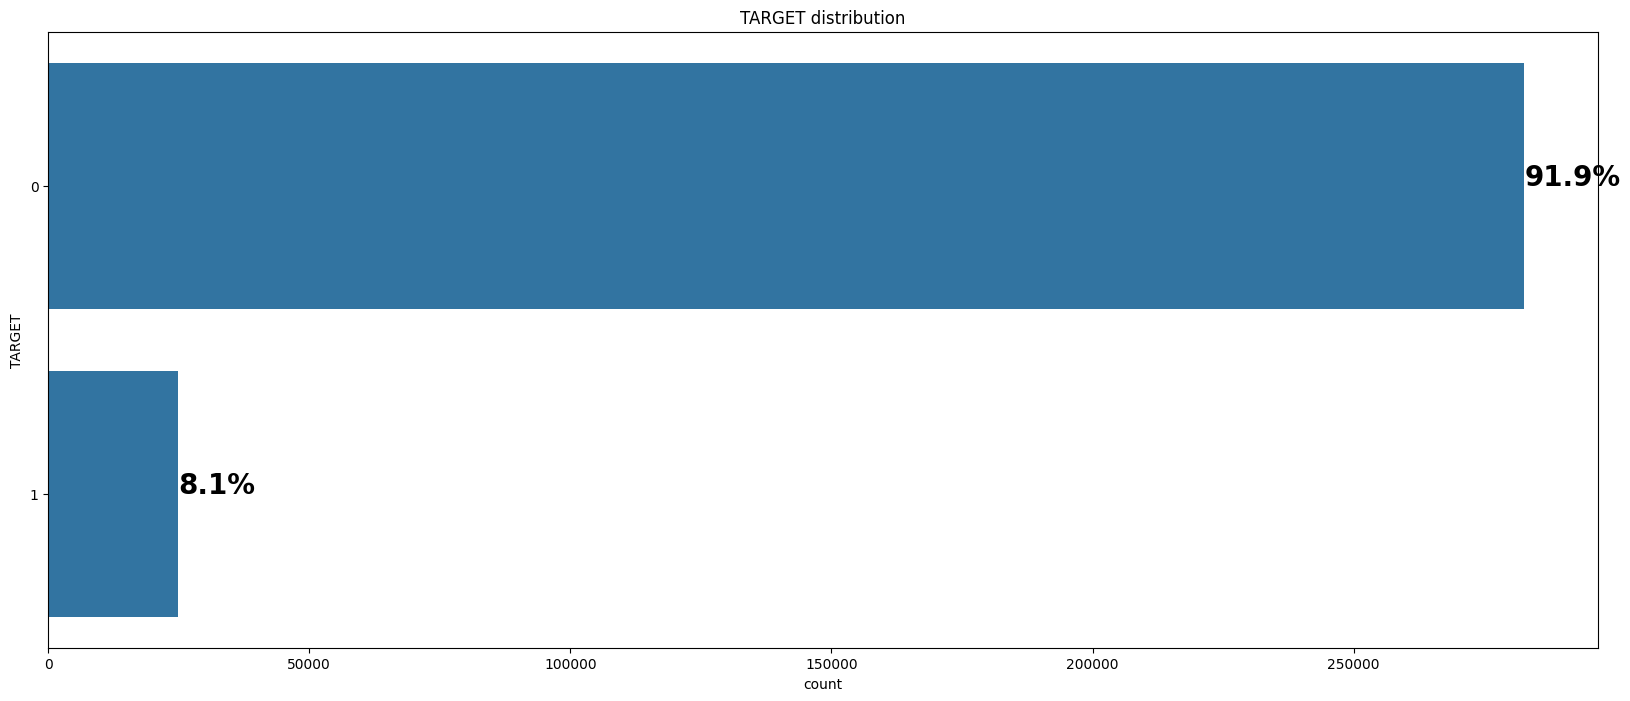

In [ ]:
ax, fig = plt.subplots(figsize=(20,8))
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

show()

valeur unique par class

In [ ]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


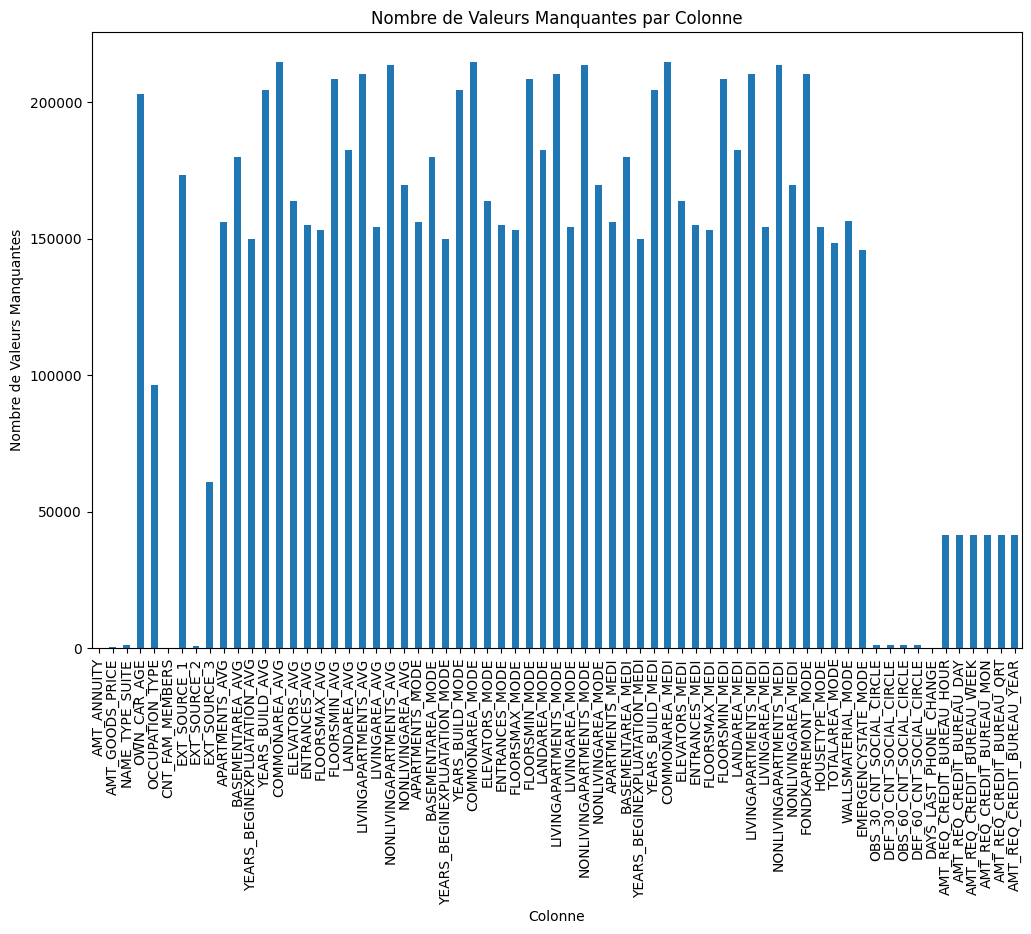

In [ ]:
# Visualisation des valeurs manquantes pour chaque colonne
missing_values = application_train.isna().sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(12, 8))
missing_values.plot(kind='bar')
plt.title('Nombre de Valeurs Manquantes par Colonne')
plt.xlabel('Colonne')
plt.ylabel('Nombre de Valeurs Manquantes')
plt.show()


In [ ]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2],
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train)[:15]

TOP 10 Missing values from Training dataset


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [ ]:
# Calculer le nombre total de colonnes
total_columns = application_train.shape[1]

# Calculer le nombre de colonnes contenant des valeurs manquantes
columns_with_missing_values = application_train.columns[application_train.isna().any()].size

# Calculer la proportion
proportion_with_missing_values = columns_with_missing_values / total_columns

# Afficher les résultats
print(f'Nombre total de colonnes : {total_columns}')
print(f'Nombre de colonnes avec des valeurs manquantes : {columns_with_missing_values}')
print(f'Proportion de colonnes avec des valeurs manquantes : {proportion_with_missing_values:.2%}')

Nombre total de colonnes : 122
Nombre de colonnes avec des valeurs manquantes : 67
Proportion de colonnes avec des valeurs manquantes : 54.92%


traitement des données incorrecte

<ipython-input-1-d7648ebebfd9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-1-d7648ebebfd9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


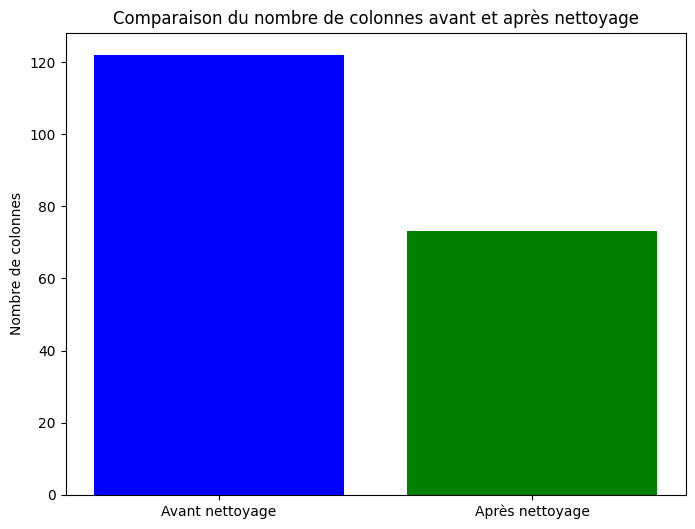

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour charger et nettoyer les données, avec comparaison du nombre de colonnes
def load_and_compare_columns(train_file_path):
    # Charger les données, en spécifiant error_bad_lines=False pour ignorer les lignes problématiques
    df = pd.read_csv(train_file_path, on_bad_lines='skip') # Ignores lines with too many fields

    # Compter les colonnes avant nettoyage
    initial_columns = df.shape[1]

    # Supprimer les colonnes avec plus de 50% de valeurs manquantes
    threshold = len(df) * 0.6
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    # Remplacer les valeurs manquantes restantes par la médiane (si numérique) ou le mode (si catégorique)
    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Compter les colonnes après nettoyage
    cleaned_columns = df_cleaned.shape[1]

    return initial_columns, cleaned_columns

# Visualisation du nombre de colonnes avant et après le nettoyage
def visualize_column_reduction(initial_columns, cleaned_columns):
    labels = ['Avant nettoyage', 'Après nettoyage']
    values = [initial_columns, cleaned_columns]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green'])
    plt.title('Comparaison du nombre de colonnes avant et après nettoyage')
    plt.ylabel('Nombre de colonnes')
    plt.show()

# Utilisation des fonctions
train_data_path = 'application_train.csv'  # Chemin vers ton fichier de données
initial_columns, cleaned_columns = load_and_compare_columns(train_data_path)

# Afficher la comparaison visuelle
visualize_column_reduction(initial_columns, cleaned_columns)



Oversampling (avec SMOTE).
Undersampling (avec RandomUnderSampler).
Ajustement des poids des classes (avec la pondération class_weight='balanced' dans le modèle).
Ensuite, je vais comparer les trois modèles à travers des graphiques, et sélectionner celui qui donne les meilleurs résultats pour poursuivre.

1. Préparation des données
Je vais préparer les données pour ces trois méthodes, puis entraîner un modèle (par exemple, RandomForest) pour chaque méthode. Je vais comparer les résultats en termes de performance (par exemple, AUC, Accuracy, F1-Score).

2. Entraînement et comparaison des modèles
Nous allons utiliser la bibliothèque imblearn pour l'oversampling et l'undersampling, et sklearn pour l'ajustement des poids.

<ipython-input-3-1c03b417cb83>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-3-1c03b417cb83>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


Méthode : SMOTE Oversampling
AUC : 0.5106
Accuracy : 0.9173
F1-Score : 0.0467
Méthode : Undersampling
AUC : 0.6777
Accuracy : 0.6926
F1-Score : 0.2585


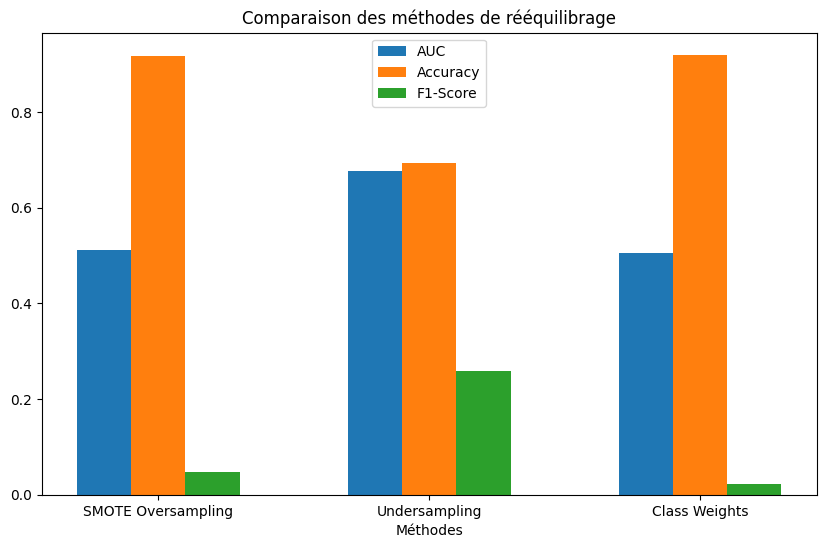

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Fonction pour charger, nettoyer et encoder les données
def load_and_clean_data(train_file_path):
    df = pd.read_csv(train_file_path, on_bad_lines='skip')
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Encodage des variables catégoriques
    df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

    X = df_encoded.drop(columns='TARGET', axis=1)
    y = df_encoded['TARGET']

    return X, y

# Appliquer le nettoyage et encodage des données
train_data_path = 'application_train.csv'  # Ton fichier CSV
X, y = load_and_clean_data(train_data_path)

# Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Méthode 1 : Oversampling avec SMOTE
def smote_oversampling(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Méthode 2 : Undersampling
def undersampling(X_train, y_train):
    undersample = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Méthode 3 : Ajustement des poids des classes
def weighted_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, model

# Fonction pour entraîner et évaluer les modèles
def evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, method_name):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    # Calcul des métriques
    auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Méthode : {method_name}")
    print(f"AUC : {auc:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("="*30)

    return auc, accuracy, f1

# Comparaison des trois méthodes
results = []

# 1. SMOTE (Oversampling)
X_resampled_smote, y_resampled_smote = smote_oversampling(X_train, y_train)
results.append(evaluate_model(X_resampled_smote, y_resampled_smote, X_test, y_test, "SMOTE Oversampling"))

# 2. Undersampling
X_resampled_under, y_resampled_under = undersampling(X_train, y_train)
results.append(evaluate_model(X_resampled_under, y_resampled_under, X_test, y_test, "Undersampling"))

# 3. Ajustement des poids (Class weight)
y_pred_weighted, model_weighted = weighted_model(X_train, y_train, X_test, y_test)
auc_weighted = roc_auc_score(y_test, y_pred_weighted)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)
results.append((auc_weighted, accuracy_weighted, f1_weighted))

# Visualisation des résultats
def plot_comparison(results):
    methods = ['SMOTE Oversampling', 'Undersampling', 'Class Weights']
    auc_scores = [result[0] for result in results]
    accuracy_scores = [result[1] for result in results]
    f1_scores = [result[2] for result in results]

    x = np.arange(len(methods))
    width = 0.2

    plt.figure(figsize=(10, 6))

    plt.bar(x - width, auc_scores, width, label='AUC')
    plt.bar(x, accuracy_scores, width, label='Accuracy')
    plt.bar(x + width, f1_scores, width, label='F1-Score')

    plt.xlabel('Méthodes')
    plt.title('Comparaison des méthodes de rééquilibrage')
    plt.xticks(x, methods)
    plt.legend()

    plt.show()

# Afficher la comparaison
plot_comparison(results)


Optimiser les hyperparamètres du modèle.


Calculer et ajuster le seuil de décision en fonction du score métier.

Visualiser les performances pour déterminer les clients à accepter ou non.




<ipython-input-3-ebfbebbaa678>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-3-ebfbebbaa678>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


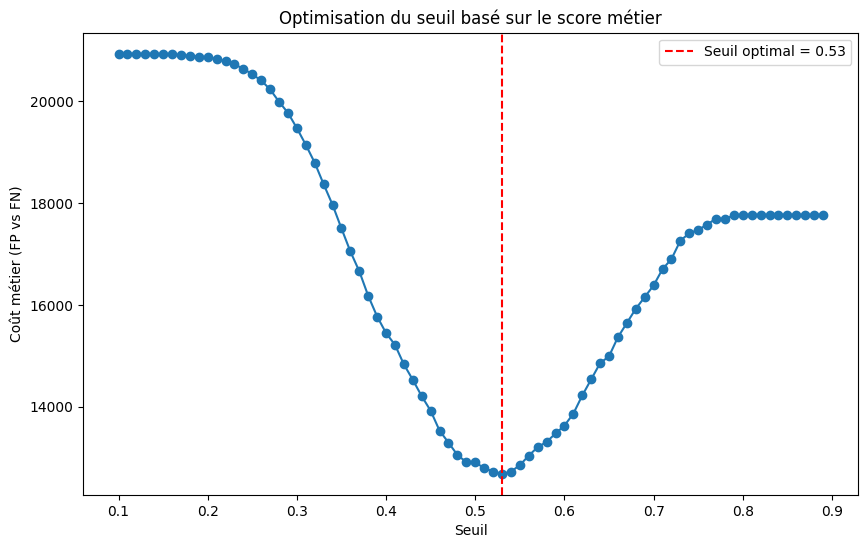

Seuil optimal pour minimiser le coût métier : 0.5299999999999998
AUC : 0.6657
Accuracy : 0.7335
F1-Score : 0.2557
Matrice de confusion :
 [[15617  5316]
 [  737  1040]]


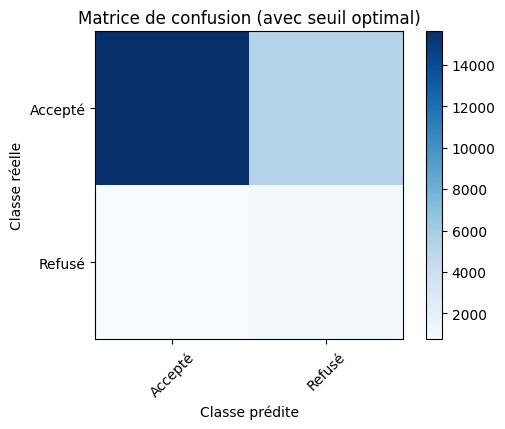

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# Fonction pour charger, nettoyer et encoder les données
def load_and_clean_data(train_file_path):
    df = pd.read_csv(train_file_path)
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Encodage des variables catégoriques
    df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

    X = df_encoded.drop(columns='TARGET', axis=1)
    y = df_encoded['TARGET']

    return X, y

# Charger et préparer les données
train_data_path = 'application_train.csv'  # Ton fichier CSV
X, y = load_and_clean_data(train_data_path)

# Séparer les données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Appliquer l'undersampling pour le rééquilibrage
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_under, y_train_under)

# Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédire les probabilités sur le jeu de test pour ajuster le seuil
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer le coût métier en fonction du seuil
def calculate_business_cost(y_true, y_pred_proba, threshold, cost_fp=1, cost_fn=10):
    y_pred = (y_pred_proba >= threshold).astype(int)
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return cost_fp * fp + cost_fn * fn

# Trouver le seuil optimal en minimisant le coût métier
thresholds = np.arange(0.1, 0.9, 0.01)
costs = [calculate_business_cost(y_test, y_pred_proba, t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Visualiser le coût métier en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.2f}')
plt.title("Optimisation du seuil basé sur le score métier")
plt.xlabel("Seuil")
plt.ylabel("Coût métier (FP vs FN)")
plt.legend()
plt.show()

print(f"Seuil optimal pour minimiser le coût métier : {best_threshold}")

# Prédire la classe finale avec le seuil optimal
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Évaluer les performances finales
auc = roc_auc_score(y_test, y_pred_final)
accuracy = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
cm = confusion_matrix(y_test, y_pred_final)

print(f"AUC : {auc:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Matrice de confusion :\n", cm)

# Visualiser la matrice de confusion
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion (avec seuil optimal)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Accepté', 'Refusé'], rotation=45)
plt.yticks(tick_marks, ['Accepté', 'Refusé'])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


Charger et nettoyer les données, encoder les variables.

Diviser les données en ensembles d'entraînement et de test.

Appliquer SMOTE pour équilibrer les classes dans le jeu d’entraînement.

Optimiser les hyperparamètres avec GridSearchCV sur le jeu d’entraînement rééquilibré.

Ajuster le seuil de décision en fonction du score métier pour minimiser les coûts des erreurs.




<ipython-input-12-6b95e8b544c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-12-6b95e8b544c7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


Meilleurs hyperparamètres : {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


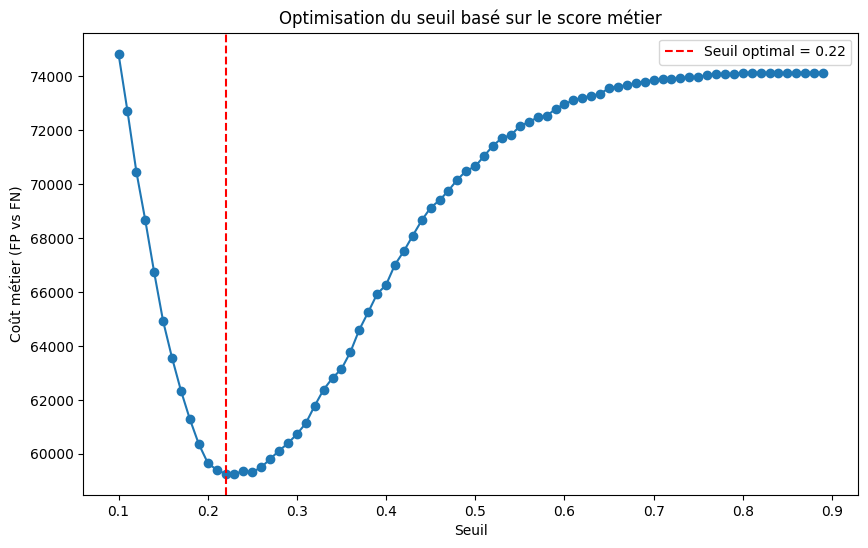

Seuil optimal pour minimiser le coût métier : 0.21999999999999995
AUC : 0.6287
Accuracy : 0.6106
F1-Score : 0.2116
Matrice de confusion :
 [[51507 33334]
 [ 2593  4820]]


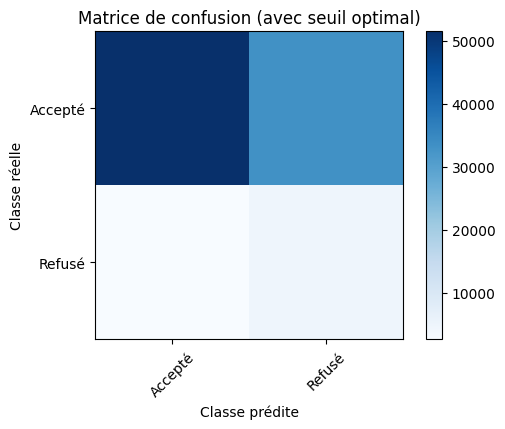

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

# Fonction pour charger, nettoyer et encoder les données
def load_and_clean_data(train_file_path):
    df = pd.read_csv(train_file_path, on_bad_lines='skip')
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Encodage des variables catégoriques
    df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

    X = df_encoded.drop(columns='TARGET', axis=1)
    y = df_encoded['TARGET']

    return X, y

# Charger et préparer les données
train_data_path = 'application_train.csv'  # Ton fichier CSV
X, y = load_and_clean_data(train_data_path)

# Séparer les données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Appliquer SMOTE pour le rééquilibrage
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_smote, y_train_smote)

# Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédire les probabilités sur le jeu de test pour ajuster le seuil
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer le coût métier en fonction du seuil
def calculate_business_cost(y_true, y_pred_proba, threshold, cost_fp=1, cost_fn=10):
    y_pred = (y_pred_proba >= threshold).astype(int)
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return cost_fp * fp + cost_fn * fn

# Trouver le seuil optimal en minimisant le coût métier
thresholds = np.arange(0.1, 0.9, 0.01)
costs = [calculate_business_cost(y_test, y_pred_proba, t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Visualiser le coût métier en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.2f}')
plt.title("Optimisation du seuil basé sur le score métier")
plt.xlabel("Seuil")
plt.ylabel("Coût métier (FP vs FN)")
plt.legend()
plt.show()

print(f"Seuil optimal pour minimiser le coût métier : {best_threshold}")

# Prédire la classe finale avec le seuil optimal
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Évaluer les performances finales
auc = roc_auc_score(y_test, y_pred_final)
accuracy = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
cm = confusion_matrix(y_test, y_pred_final)

print(f"AUC : {auc:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Matrice de confusion :\n", cm)

# Visualiser la matrice de confusion
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion (avec seuil optimal)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Accepté', 'Refusé'], rotation=45)
plt.yticks(tick_marks, ['Accepté', 'Refusé'])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


**Chargement et préparation des données :** Le code charge et nettoie les données, puis effectue un encodage des variables catégoriques.

***Class Weight ***: Ici, nous n’appliquons pas de technique de rééquilibrage sur les données. Au lieu de cela, nous utilisons class_weight='balanced' dans le modèle RandomForest pour compenser le déséquilibre des classes.

**Optimisation des hyperparamètres :** Nous utilisons GridSearchCV pour optimiser les paramètres du modèle RandomForest avec la pondération des classes activée.

**Calcul du seuil optimal :** Comme pour les versions précédentes, nous trouvons le seuil optimal pour minimiser le coût métier.

**Évaluation des performances finales :** Le modèle est évalué en utilisant le seuil optimal, et les performances sont affichées (AUC, accuracy, F1-score) avec une matrice de confusion.

<ipython-input-6-7716c4c70c0a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-6-7716c4c70c0a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs hyperparamètres : {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}


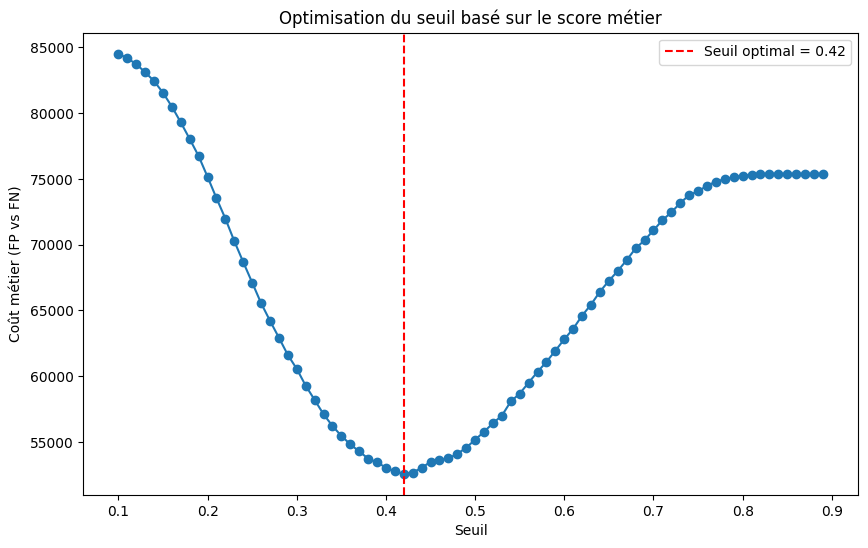

Seuil optimal pour minimiser le coût métier : 0.4199999999999998
AUC : 0.6700
Accuracy : 0.7070
F1-Score : 0.2576
Matrice de confusion :
 [[60909 24384]
 [ 2820  4719]]


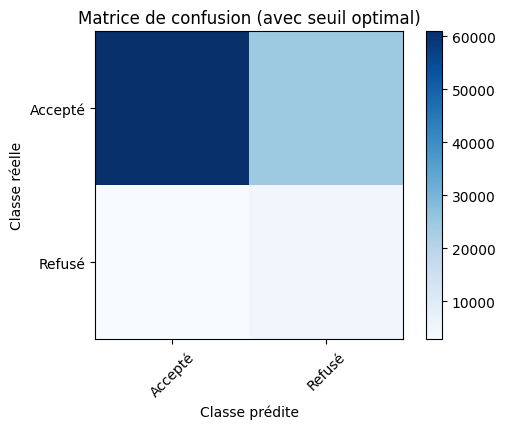

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# Fonction pour charger, nettoyer et encoder les données
def load_and_clean_data(train_file_path):
    df = pd.read_csv(train_file_path, on_bad_lines='skip')
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Encodage des variables catégoriques
    df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

    X = df_encoded.drop(columns='TARGET', axis=1)
    y = df_encoded['TARGET']

    return X, y

# Charger et préparer les données
train_data_path = 'application_train.csv'  # Ton fichier CSV
X, y = load_and_clean_data(train_data_path)

# Séparer les données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optimisation des hyperparamètres avec GridSearchCV en utilisant class_weight='balanced'
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Utilisation de class_weight='balanced' dans le modèle
model = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédire les probabilités sur le jeu de test pour ajuster le seuil
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer le coût métier en fonction du seuil
def calculate_business_cost(y_true, y_pred_proba, threshold, cost_fp=1, cost_fn=10):
    y_pred = (y_pred_proba >= threshold).astype(int)
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return cost_fp * fp + cost_fn * fn

# Trouver le seuil optimal en minimisant le coût métier
thresholds = np.arange(0.1, 0.9, 0.01)
costs = [calculate_business_cost(y_test, y_pred_proba, t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Visualiser le coût métier en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.2f}')
plt.title("Optimisation du seuil basé sur le score métier")
plt.xlabel("Seuil")
plt.ylabel("Coût métier (FP vs FN)")
plt.legend()
plt.show()

print(f"Seuil optimal pour minimiser le coût métier : {best_threshold}")

# Prédire la classe finale avec le seuil optimal
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Évaluer les performances finales
auc = roc_auc_score(y_test, y_pred_final)
accuracy = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
cm = confusion_matrix(y_test, y_pred_final)

print(f"AUC : {auc:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Matrice de confusion :\n", cm)

# Visualiser la matrice de confusion
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion (avec seuil optimal)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Accepté', 'Refusé'], rotation=45)
plt.yticks(tick_marks, ['Accepté', 'Refusé'])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


In [ ]:
print("%0.0f values with 365243 days employed for training data" %
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for training data" % application_train.shape[0])
print("***********************")
print("%0.0f values with 365243 days employed for testing data" %
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for testing data" % application_test.shape[0])
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#Replace outliers values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

55374 values with 365243 days employed for training data
307511 Total values from days employed for training data
***********************
9274 values with 365243 days employed for testing data
48744 Total values from days employed for testing data


DEFINITION POUR FUTUR ANALYSE

In [ ]:
def plot_stat(data, feature, title) :

    ax, fig = plt.subplots(figsize=(20,8))
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()

In [ ]:
def plot_percent_target1(data, feature, title) :

    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    ax, fig = plt.subplots(figsize=(20,8))
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()

DIFFERENT TYPES DE PRET

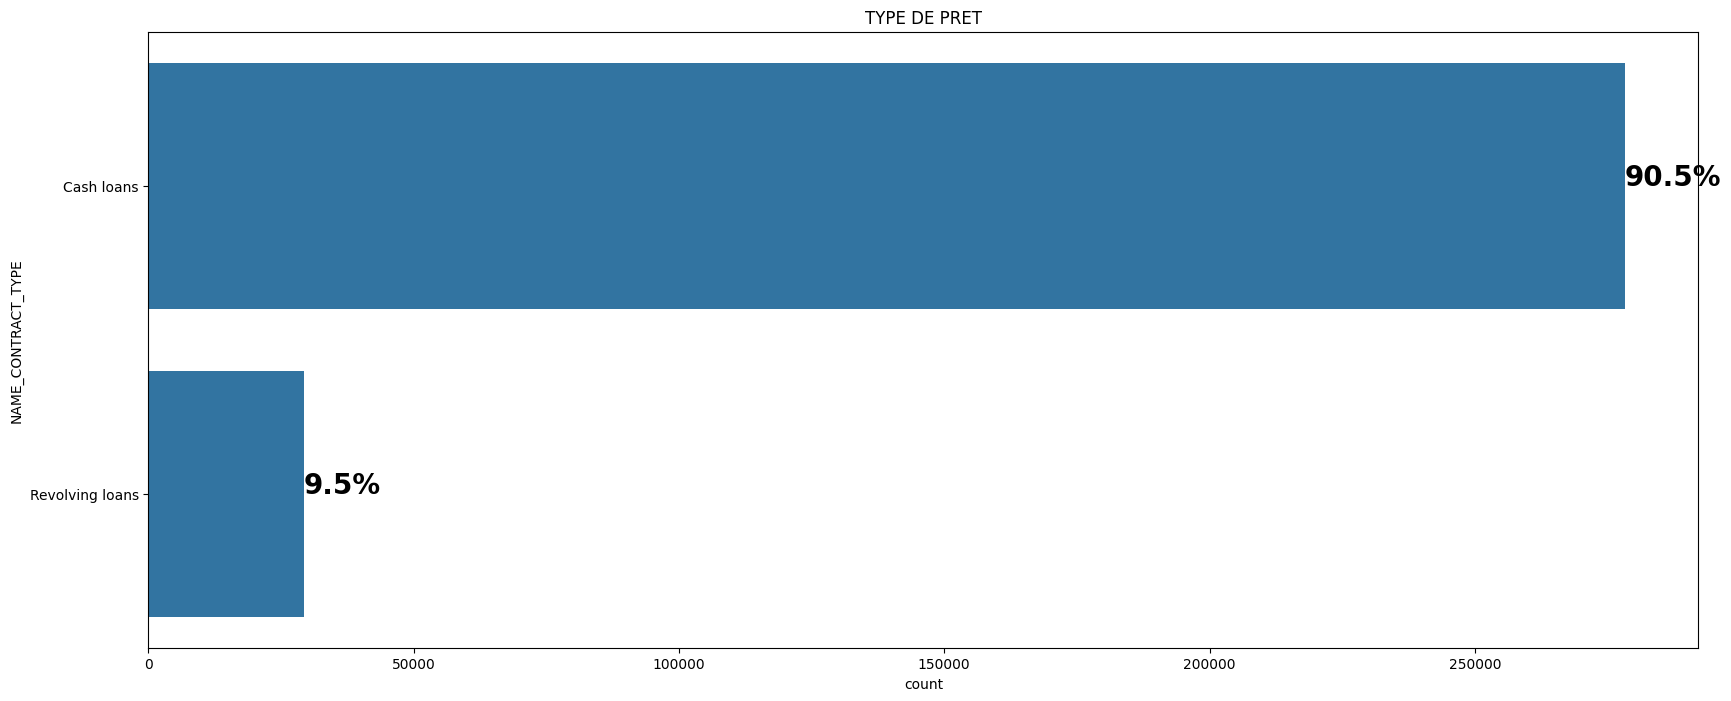

In [ ]:
#NAME_CONTRACT_TYPE
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"TYPE DE PRET")


GENRE CLIENT

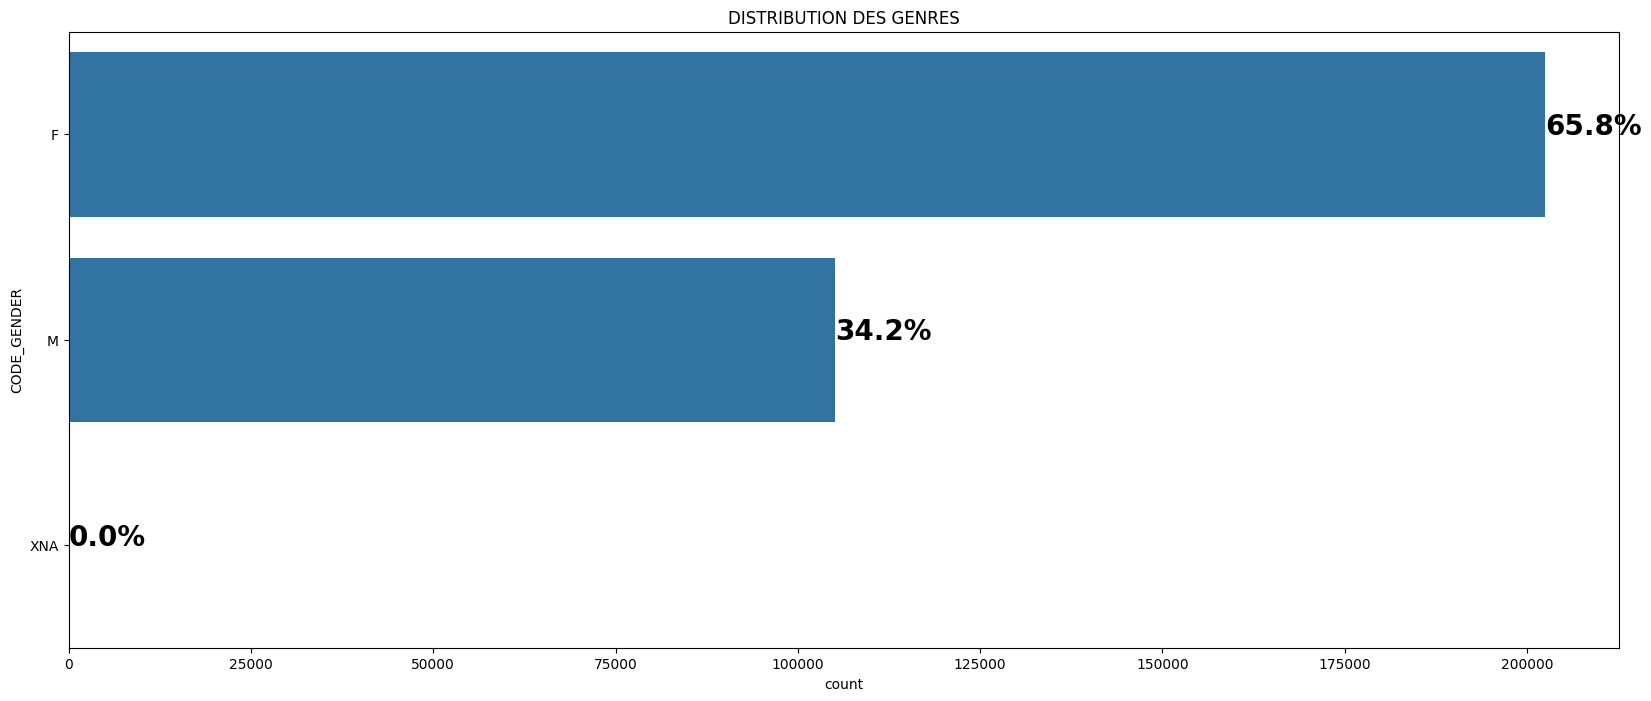

In [ ]:
#CODE_GENDER
plot_stat(application_train, 'CODE_GENDER',"DISTRIBUTION DES GENRES")


SOURCES DE REVENUE

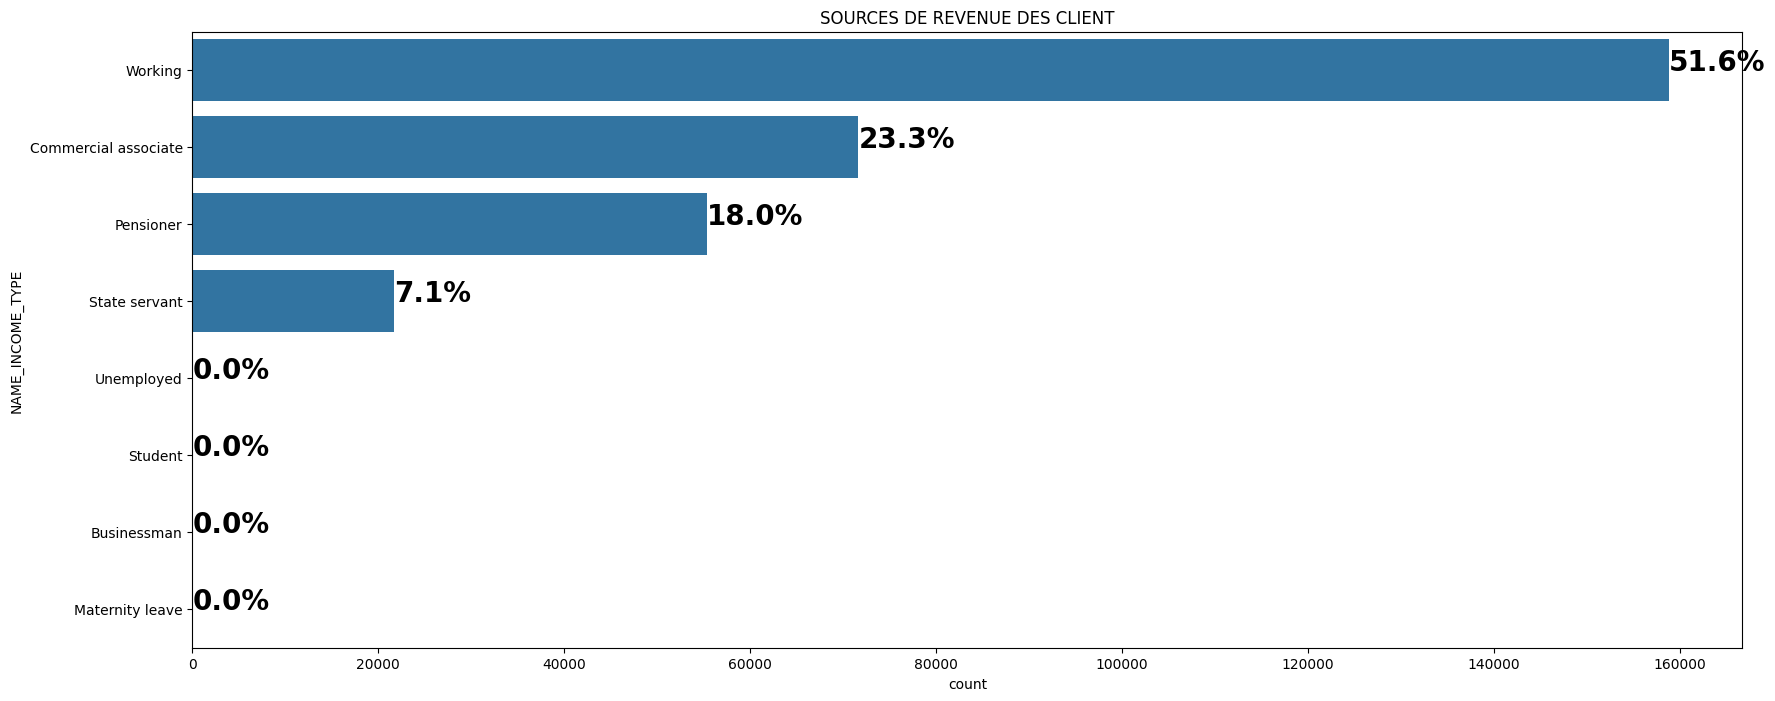

                                   -------------------------------------------------------


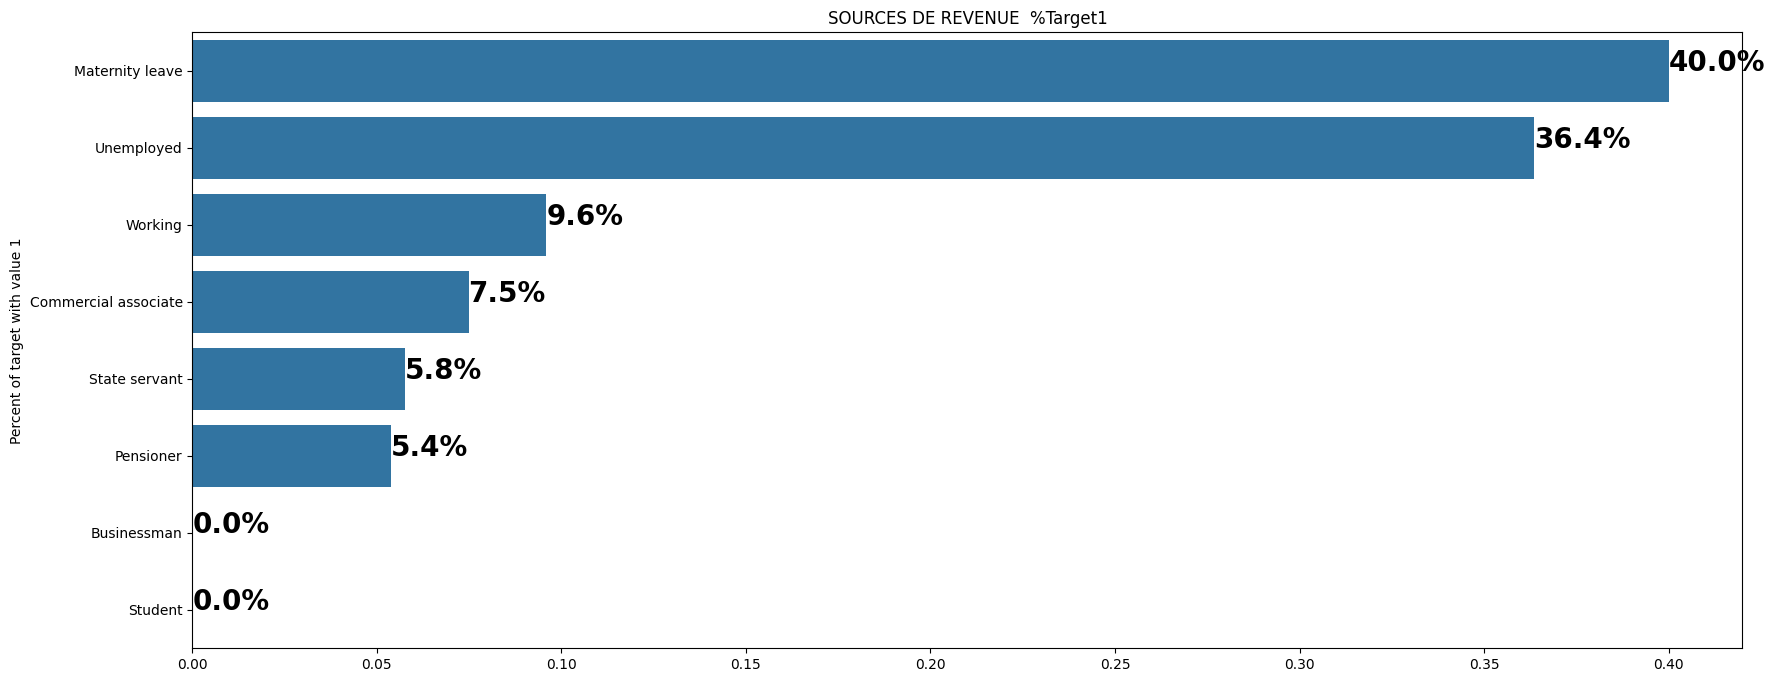

In [ ]:
#NAME_INCOME_TYPE
plot_stat(application_train, 'NAME_INCOME_TYPE',"SOURCES DE REVENUE DES CLIENT")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"SOURCES DE REVENUE  %Target1")

DEGRES D'EDUCATION DES CLIENTS

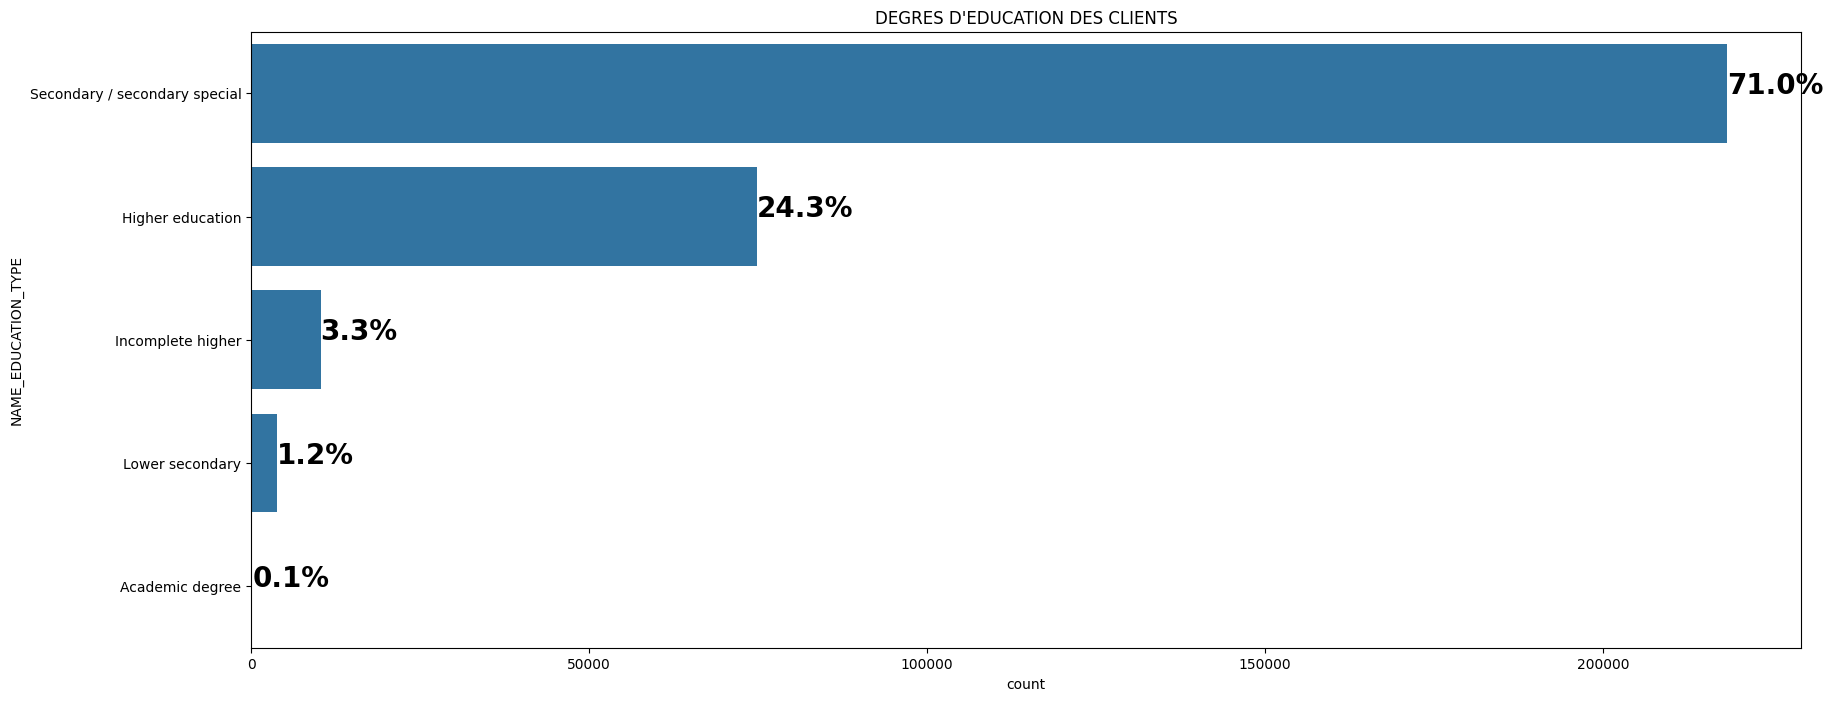

                                   -------------------------------------------------------


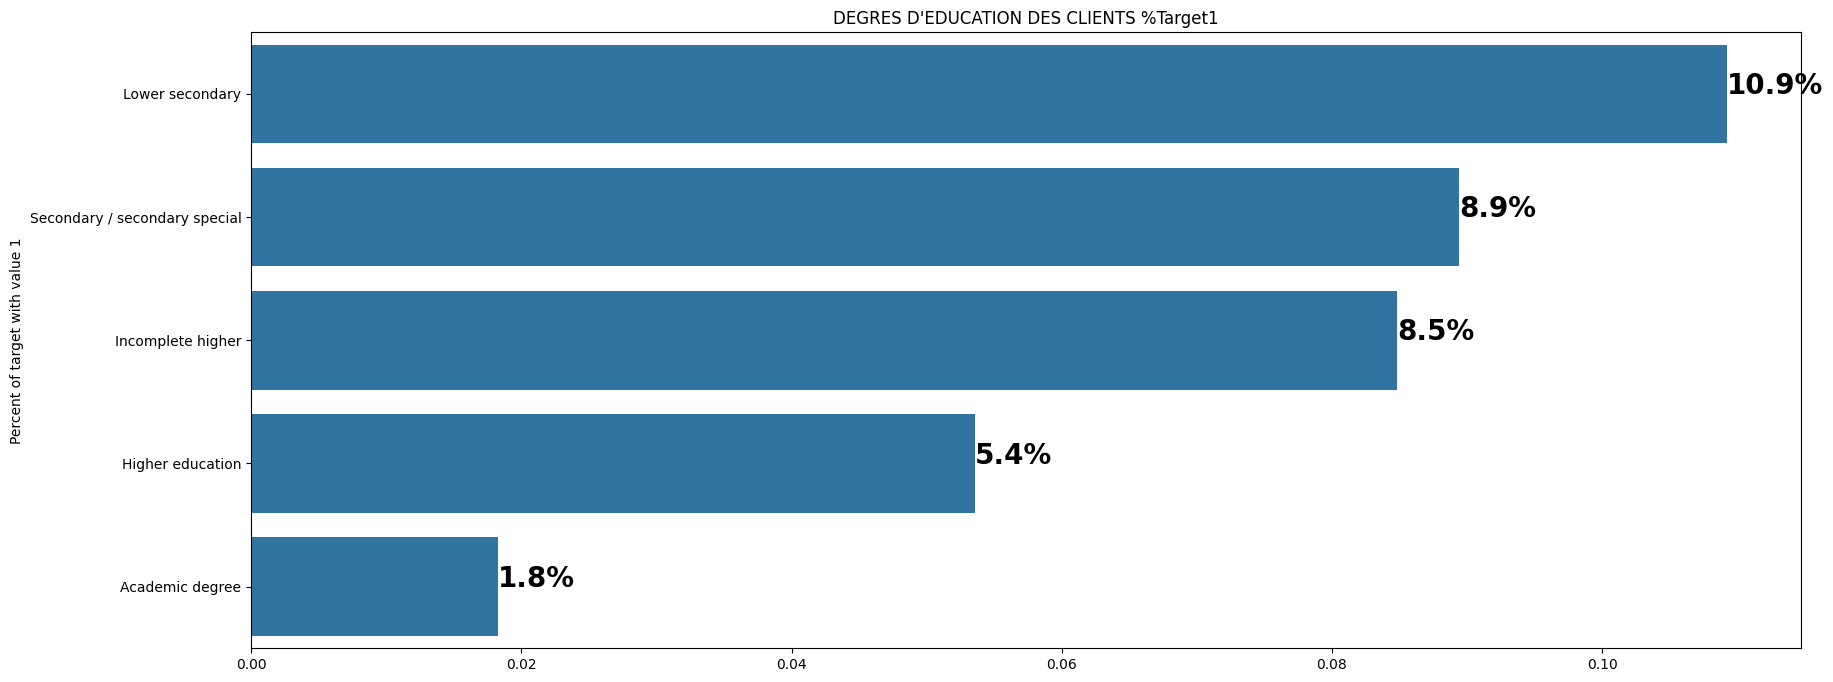

In [ ]:
#NAME_EDUCATION_TYPE
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"DEGRES D'EDUCATION DES CLIENTS")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"DEGRES D'EDUCATION DES CLIENTS %Target1")

LIEU D'habitatioon des cliens

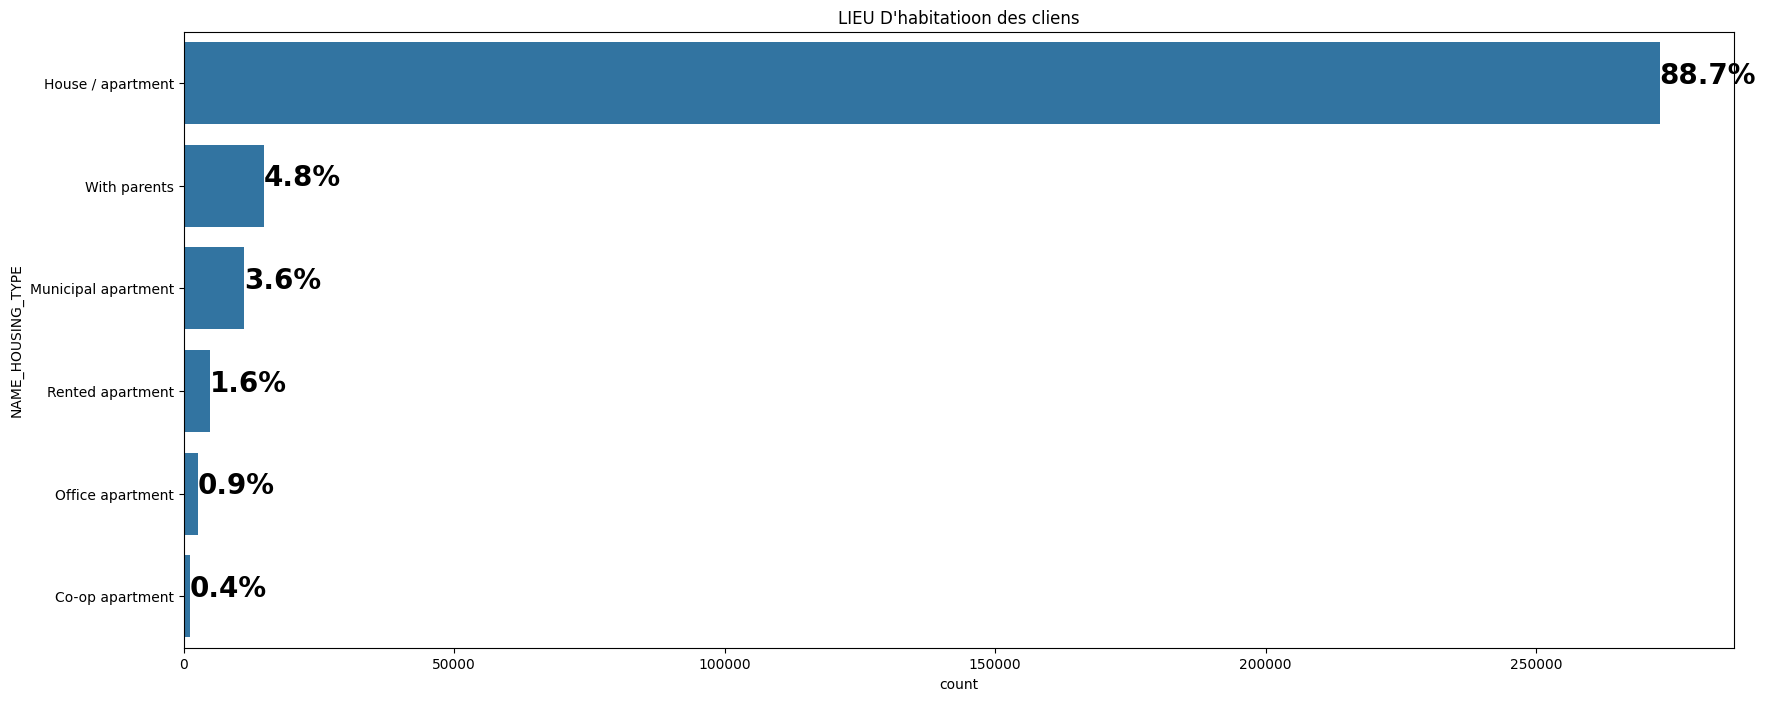

                                   -------------------------------------------------------


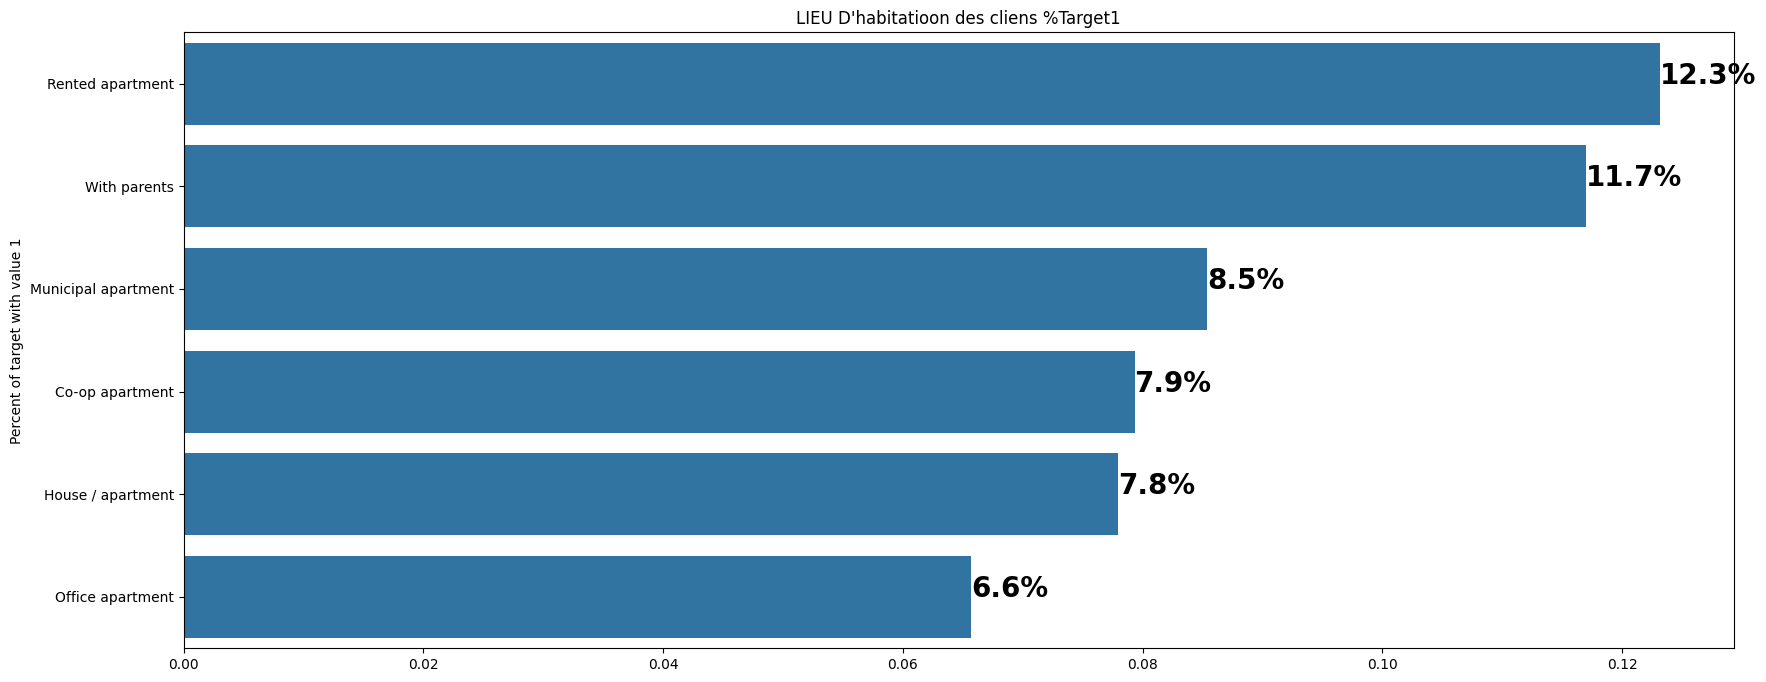

In [ ]:
#NAME_HOUSING_TYPE
plot_stat(application_train, 'NAME_HOUSING_TYPE',"LIEU D'habitatioon des cliens")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"LIEU D'habitatioon des cliens %Target1")

L'analyse peut continuer par une étape de traitement des corrélations entre les caractéristiques et la Target. L'idée est de calculer le coefficient de corrélation de Pearson entre chaque variable et la Target. Cette étape permet d'avoir un aperçu des relations possibles entre les variables.

<ipython-input-50-26c370b88f96>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_positive_corr.values, y=most_positive_corr.index, palette='viridis')
<ipython-input-50-26c370b88f96>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_negative_corr.values, y=most_negative_corr.index, palette='viridis')


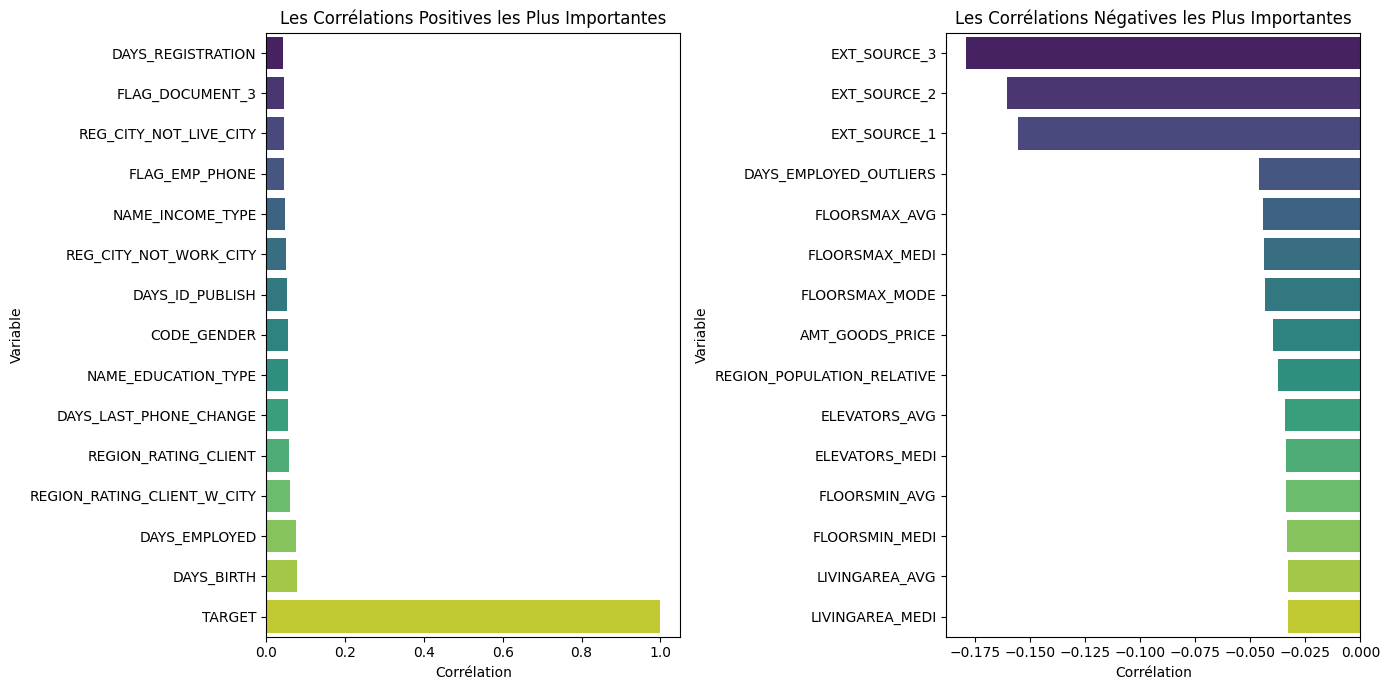

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Exemple de chargement de données (à remplacer par vos données)
# application_train = pd.read_csv('votre_fichier.csv')

# Convertir les variables catégorielles en numériques
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Prétraiter les données (encodage des variables catégorielles)
application_train_encoded = encode_categorical_columns(application_train.copy())

# Calculer la corrélation avec TARGET
correlation_with_target = application_train_encoded.corr()['TARGET']

# Corrélations positives les plus importantes
most_positive_corr = correlation_with_target.sort_values().tail(15)

# Corrélations négatives les plus importantes
most_negative_corr = correlation_with_target.sort_values().head(15)

# Configuration des graphiques
plt.figure(figsize=(14, 7))

# Graphique des corrélations positives
plt.subplot(1, 2, 1)
sns.barplot(x=most_positive_corr.values, y=most_positive_corr.index, palette='viridis')
plt.title('Les Corrélations Positives les Plus Importantes')
plt.xlabel('Corrélation')
plt.ylabel('Variable')

# Graphique des corrélations négatives
plt.subplot(1, 2, 2)
sns.barplot(x=most_negative_corr.values, y=most_negative_corr.index, palette='viridis')
plt.title('Les Corrélations Négatives les Plus Importantes')
plt.xlabel('Corrélation')
plt.ylabel('Variable')

# Ajuster l'espacement des sous-graphiques
plt.tight_layout()
plt.show()


Sources externes les plus fortes

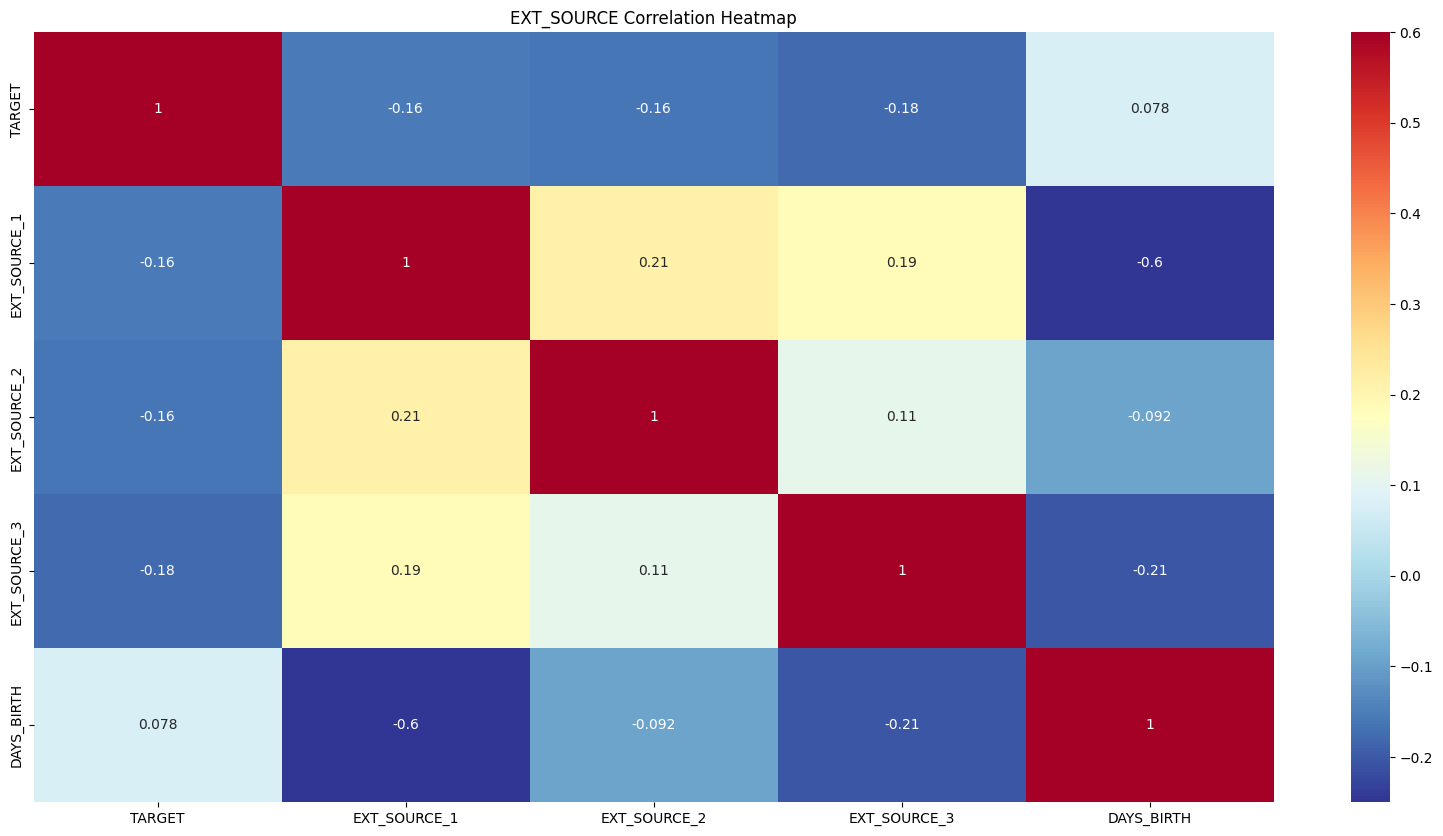

In [ ]:
#Heatmap of correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
show()

In [1]:
import random
import pytest

# Exemple de fonction fictive pour les tests
def predict_credit(client_id: int):
    """
    Simule une prédiction basée uniquement sur le client_id.
    Retourne aléatoirement 1 (crédit accordé) ou 0 (crédit refusé).
    """
    if not isinstance(client_id, int):
        raise ValueError("client_id doit être un entier.")
    if client_id < 0:
        raise ValueError("client_id ne peut pas être négatif.")
    return random.choice([0, 1])

# 1. Test du type de retour
def test_predict_return_type():
    result = predict_credit(12345)
    assert isinstance(result, int), "La fonction doit retourner un entier."

# 2. Test des valeurs retournées
def test_predict_valid_values():
    result = predict_credit(12345)
    assert result in [0, 1], "La fonction doit retourner 0 ou 1 uniquement."

# 3. Test des exceptions pour des entrées non valides
def test_predict_invalid_client_id():
    with pytest.raises(ValueError, match="client_id doit être un entier."):
        predict_credit("abc")  # Cas non entier

    with pytest.raises(ValueError, match="client_id doit être un entier."):
        predict_credit(12.34)  # Cas float

    with pytest.raises(ValueError, match="client_id ne peut pas être négatif."):
        predict_credit(-10)  # Cas négatif

# 4. Test des comportements avec des valeurs limites
def test_predict_edge_cases():
    assert predict_credit(0) in [0, 1], "La fonction doit gérer un client_id de 0."
    assert predict_credit(999999999) in [0, 1], "La fonction doit gérer de très grands client_id."

# 5. Test de robustesse pour des cas extrêmes
def test_predict_empty_input():
    with pytest.raises(TypeError):
        predict_credit()  # Aucun argument fourni

# 6. Test de variabilité
def test_predict_random_behavior():
    results = [predict_credit(12345) for _ in range(100)]
    assert 0 in results and 1 in results, "La fonction doit retourner à la fois 0 et 1 dans différents cas."

# 7. Test de non-régression
def test_predict_consistency():
    random.seed(42)  # Fixer la graine pour un comportement reproductible
    result_1 = predict_credit(12345)
    random.seed(42)
    result_2 = predict_credit(12345)
    assert result_1 == result_2, "La fonction doit être reproductible avec une graine fixe."


In [3]:
!pip install evidently


In [9]:
import pandas as pd
import numpy as np

# Charger les données avec gestion des erreurs de ligne
file_path = "/content/application_train.csv"  # Remplacez par votre chemin réel

try:
    # Lecture avec gestion des lignes problématiques
    data = pd.read_csv(file_path, on_bad_lines="skip", engine="python")

    # Aperçu initial des données
    print("Aperçu initial des données :")
    print(data.head())

    # 1. Supprimer les colonnes avec trop de valeurs manquantes
    missing_threshold = 0.3  # Seuil : supprimer les colonnes avec plus de 30 % de valeurs manquantes
    missing_percentages = data.isnull().mean()
    columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index

    print(f"\nColonnes supprimées (trop de valeurs manquantes > {missing_threshold * 100} %) :")
    print(columns_to_drop.tolist())

    data_cleaned = data.drop(columns=columns_to_drop)

    # 2. Imputer les valeurs manquantes restantes
    # Pour les colonnes numériques : remplacer par la médiane
    num_columns = data_cleaned.select_dtypes(include=[np.number]).columns
    data_cleaned[num_columns] = data_cleaned[num_columns].fillna(data_cleaned[num_columns].median())

    # Pour les colonnes catégoriques : remplacer par le mode
    cat_columns = data_cleaned.select_dtypes(exclude=[np.number]).columns
    data_cleaned[cat_columns] = data_cleaned[cat_columns].fillna(data_cleaned[cat_columns].mode().iloc[0])

    print("\nValeurs manquantes après traitement :")
    print(data_cleaned.isnull().sum())

    # 3. Supprimer les doublons
    data_cleaned = data_cleaned.drop_duplicates()
    print(f"\nNombre de lignes après suppression des doublons : {data_cleaned.shape[0]}")

    # 4. Vérification finale
    print("\nAperçu des données nettoyées :")
    print(data_cleaned.head())

    # Afficher les colonnes disponibles
    print("\nColonnes disponibles après nettoyage :")
    print(data_cleaned.columns.tolist())

    # Sauvegarder les données nettoyées
    data_cleaned.to_csv("/content/cleaned_data.csv", index=False)
    print("\nDonnées nettoyées sauvegardées dans 'cleaned_data.csv'")

except pd.errors.ParserError as e:
    print("Erreur de parsing lors du chargement du fichier :", str(e))
except Exception as e:
    print("Une erreur inattendue est survenue :", str(e))


Aperçu initial des données :
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...  

In [ ]:
# Installer les bibliothèques nécessaires
!pip install pandas shap evidently matplotlib scikit-learn nest-asyncio

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, ClassificationPreset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nest_asyncio

# Appliquer `nest_asyncio` pour Colab
nest_asyncio.apply()

# Charger les données
file_path = "/content/cleaned_data.csv"  # Remplacez par votre chemin réel
data = pd.read_csv(file_path)

# Vérifier les données
print("Aperçu des données :")
print(data.head())

# Renommer la colonne 'TARGET' en 'target' pour Evidently
data.rename(columns={'TARGET': 'target'}, inplace=True)

# Encodage des colonnes catégoriques
cat_columns = data.select_dtypes(include=['object']).columns
print(f"\nColonnes catégoriques détectées : {cat_columns.tolist()}")

# Utiliser LabelEncoder pour convertir les colonnes catégoriques en numériques
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # Convertir en chaînes avant l'encodage
    label_encoders[col] = le

print("\nAperçu des données après encodage :")
print(data.head())

# Séparer les features et la cible
X = data.drop(columns=['target'])  # Utiliser 'target' comme colonne cible
y = data['target']

# Entraîner un modèle de démonstration
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X, y)

# Ajouter les prédictions du modèle
data['prediction'] = model.predict(X)

# 1. Générer un rapport Evidently
def generate_evidently_report(reference_data, current_data):
    """
    Génère un rapport Evidently pour analyser la dérive des données et la performance.
    """
    # Créer un rapport pour la dérive des données et la performance de classification
    report = Report(metrics=[
        DataDriftPreset(),
        ClassificationPreset()
    ])
    report.run(reference_data=reference_data, current_data=current_data)
    report.save_html("evidently_report.html")
    print("Rapport Evidently généré : evidently_report.html")

# Simuler des données actuelles pour la dérive
reference_data = data.sample(frac=0.8, random_state=42)
current_data = data.sample(frac=0.8, random_state=21)
generate_evidently_report(reference_data, current_data)

# 2. Tests unitaires sur les données
def run_tests(data):
    """
    Effectue des tests unitaires pour vérifier la qualité des données.
    """
    test_results = []

    # Test 1 : Vérifier les valeurs manquantes
    if data.isnull().any().any():
        test_results.append("❌ Test des valeurs manquantes : FAIL - Données manquantes détectées.")
    else:
        test_results.append("✅ Test des valeurs manquantes : PASS")

    # Test 2 : Vérifier les doublons
    if data.duplicated().any():
        test_results.append("❌ Test des doublons : FAIL - Doublons détectés.")
    else:
        test_results.append("✅ Test des doublons : PASS")

    # Test 3 : Vérifier les colonnes numériques
    if not all(data.dtypes.isin([np.number])):
        test_results.append("❌ Test des colonnes numériques : FAIL - Données non numériques détectées.")
    else:
        test_results.append("✅ Test des colonnes numériques : PASS")

    # Résumé des tests
    print("\nRésultats des tests unitaires :")
    for result in test_results:
        print(result)

run_tests(data)

# 3. Analyse SHAP
def run_shap_analysis(model, X):
    """
    Utilise SHAP pour analyser les contributions des features.
    """
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Visualiser les valeurs SHAP
    print("\nAffichage des contributions des features avec SHAP :")
    shap.summary_plot(shap_values, X, show=True)

run_shap_analysis(model, X)



Aperçu des données :
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...          

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Rapport Evidently généré : evidently_report.html

Résultats des tests unitaires :
✅ Test des valeurs manquantes : PASS
✅ Test des doublons : PASS
❌ Test des colonnes numériques : FAIL - Données non numériques détectées.


In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, ClassificationPreset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nest_asyncio

# Appliquer `nest_asyncio` pour Colab
nest_asyncio.apply()

# Charger les données
file_path = "/content/cleaned_data.csv"  # Remplacez par votre chemin réel
data = pd.read_csv(file_path)

# Vérifier les données
print("Aperçu des données :")
print(data.head())

# Renommer la colonne 'TARGET' en 'target' pour Evidently
data.rename(columns={'TARGET': 'target'}, inplace=True)

# Encodage des colonnes catégoriques
cat_columns = data.select_dtypes(include=['object']).columns
print(f"\nColonnes catégoriques détectées : {cat_columns.tolist()}")

# Utiliser LabelEncoder pour convertir les colonnes catégoriques en numériques
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # Convertir en chaînes avant l'encodage
    label_encoders[col] = le

print("\nAperçu des données après encodage :")
print(data.head())

# Séparer les features et la cible
X = data.drop(columns=['target'])  # Utiliser 'target' comme colonne cible
y = data['target']

# Entraîner un modèle de démonstration
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X, y)

# Ajouter les prédictions du modèle
data['prediction'] = model.predict(X)

# 1. Générer un rapport Evidently
def generate_evidently_report(reference_data, current_data):
    """
    Génère un rapport Evidently pour analyser la dérive des données et la performance.
    """
    # Créer un rapport pour la dérive des données et la performance de classification
    report = Report(metrics=[
        DataDriftPreset(),
        ClassificationPreset()
    ])
    report.run(reference_data=reference_data, current_data=current_data)
    report.save_html("evidently_report.html")
    print("Rapport Evidently généré : evidently_report.html")

# Simuler des données actuelles pour la dérive
reference_data = data.sample(frac=0.8, random_state=42)
current_data = data.sample(frac=0.8, random_state=21)
generate_evidently_report(reference_data, current_data)


Aperçu des données :
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...          

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Rapport Evidently généré : evidently_report.html


In [8]:
import pandas as pd
import numpy as np
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Charger les données nettoyées
data_path = "/content/cleaned_data.csv"  # Remplacez par le chemin de vos données nettoyées
data = pd.read_csv(data_path)

# Préparer les features (X) et la cible (y)
target_column = "TARGET"  # Remplacez par le nom de la colonne cible
if target_column not in data.columns:
    raise ValueError(f"La colonne cible '{target_column}' est absente des données.")

X = data.drop(columns=[target_column])
y = data[target_column]

# Vérifier les colonnes catégoriques et les encoder si nécessaire
cat_columns = X.select_dtypes(include=['object']).columns
if not cat_columns.empty:
    print(f"Colonnes catégoriques détectées : {cat_columns.tolist()}")
    from sklearn.preprocessing import LabelEncoder
    for col in cat_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle LightGBM
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Sauvegarder le modèle
model_path = "/content/trained_model.pkl"
joblib.dump(model, model_path)
print(f"\nModèle sauvegardé dans : {model_path}")

# Sauvegarder les colonnes utilisées pour l'entraînement
columns_path = "/content/model_columns.pkl"
joblib.dump(X.columns.tolist(), columns_path)
print(f"Colonnes sauvegardées dans : {columns_path}")



Colonnes catégoriques détectées : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3389
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.54      0.02      

In [11]:
# Vérifier la présence de NaN, Inf ou -Inf dans les colonnes
print("\nValeurs inhabituelles détectées :")
print(data[~data.applymap(np.isfinite)].count())



Valeurs inhabituelles détectées :


<ipython-input-11-b1ee19261966>:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



SK_ID_CURR                    0
target                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
prediction                    0
Length: 73, dtype: int64


In [12]:


# 2. Tests unitaires sur les données
def run_tests(data):
    """
    Effectue des tests unitaires pour vérifier la qualité des données.
    """
    test_results = []

    # Test 1 : Vérifier les valeurs manquantes
    if data.isnull().any().any():
        test_results.append("❌ Test des valeurs manquantes : FAIL - Données manquantes détectées.")
    else:
        test_results.append("✅ Test des valeurs manquantes : PASS")

    # Test 2 : Vérifier les doublons
    if data.duplicated().any():
        test_results.append("❌ Test des doublons : FAIL - Doublons détectés.")
    else:
        test_results.append("✅ Test des doublons : PASS")


        test_results.append("✅ Test des colonnes numériques : PASS")

    # Résumé des tests
    print("\nRésultats des tests unitaires :")
    for result in test_results:
        print(result)

run_tests(data)



Résultats des tests unitaires :
✅ Test des valeurs manquantes : PASS
✅ Test des doublons : PASS
✅ Test des colonnes numériques : PASS


In [11]:
import pandas as pd
import numpy as np
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Charger les données nettoyées
data_path = "/content/cleaned_data.csv"  # Remplacez par le chemin de vos données nettoyées
data = pd.read_csv(data_path)

# Préparer les features (X) et la cible (y)
target_column = "TARGET"  # Remplacez par le nom de la colonne cible
if target_column not in data.columns:
    raise ValueError(f"La colonne cible '{target_column}' est absente des données.")

X = data.drop(columns=[target_column])
y = data[target_column]

# Vérifier les colonnes catégoriques et les encoder si nécessaire
cat_columns = X.select_dtypes(include=['object']).columns
if not cat_columns.empty:
    print(f"Colonnes catégoriques détectées : {cat_columns.tolist()}")
    from sklearn.preprocessing import LabelEncoder
    for col in cat_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle LightGBM
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Sauvegarder le modèle
model_path = "/content/trained_model.pkl"
joblib.dump(model, model_path)
print(f"\nModèle sauvegardé dans : {model_path}")

# Sauvegarder les colonnes utilisées pour l'entraînement
columns_path = "/content/model_columns.pkl"
joblib.dump(X_train.columns.tolist(), columns_path)
print(f"Colonnes sauvegardées dans : {columns_path}")

# Vérification : Récupérer les colonnes sauvegardées
loaded_columns = joblib.load(columns_path)
print(f"\nColonnes récupérées : {loaded_columns}")


Colonnes catégoriques détectées : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3389
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.54      0.02      

Colonnes utilisées par le modèle : ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE

<ipython-input-13-678a56275933>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-13-678a56275933>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-13-678a56275933>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i


Colonnes catégoriques converties en numériques.

Colonnes finales synchronisées avec le modèle : ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCI

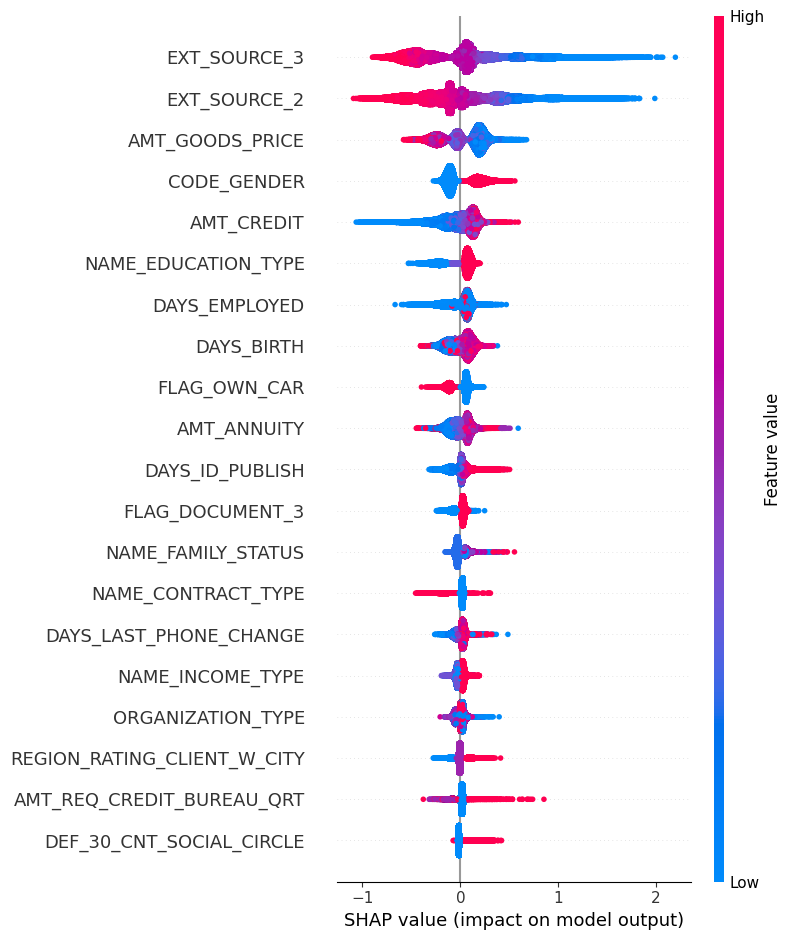

In [13]:
import shap
import pandas as pd
import joblib

# Charger les données nettoyées
data_path = "/content/cleaned_data.csv"  # Remplacez par le chemin de vos données
data = pd.read_csv(data_path)

# Charger le modèle
model_path = "/content/trained_model.pkl"  # Remplacez par le chemin de votre modèle
model = joblib.load(model_path)

# Identifier les colonnes utilisées par le modèle
if hasattr(model, "feature_name_"):
    model_columns = model.feature_name_  # LightGBM et certains modèles
else:
    raise ValueError("Impossible de récupérer les colonnes utilisées par le modèle.")

print(f"Colonnes utilisées par le modèle : {model_columns}")

# Synchroniser les colonnes entre les données et le modèle
X = data[model_columns]

# Vérifier les colonnes catégoriques
cat_columns = X.select_dtypes(include=['object']).columns
if not cat_columns.empty:
    print(f"Colonnes catégoriques détectées : {cat_columns.tolist()}")
    from sklearn.preprocessing import LabelEncoder
    for col in cat_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    print("\nColonnes catégoriques converties en numériques.")

# Afficher les colonnes finales utilisées
print(f"\nColonnes finales synchronisées avec le modèle : {X.columns.tolist()}")

# Tentative avec SHAP
try:
    print("\nTentative avec SHAP TreeExplainer...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)

    # Visualiser les contributions des features
    print("\nAffichage des contributions des features avec SHAP :")
    shap.summary_plot(shap_values, X, show=True)
except Exception as e:
    print(f"Erreur dans l'analyse SHAP : {e}")


2) Feature enginnering

Definition

In [ ]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Lire les données et fusionner
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)

    print("application_test samples: {}".format(len(test_df)))
    print("application_train samples: {}, application_test samples: {}".format(len(df), len(test_df)))

    # Remplacer append par pd.concat pour éviter l'erreur
    df = pd.concat([df, test_df], ignore_index=True).reset_index(drop=True)

    # Retirer les applications avec CODE_GENDER 'XNA'
    df = df[df['CODE_GENDER'] != 'XNA']

    # Encodage binaire des variables catégorielles
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Encodage One-Hot des variables catégorielles restantes
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Remplacement des valeurs aberrantes
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['AMT_INCOME_TOTAL'].replace(1.170000e+08, np.nan, inplace=True)

    # Création de nouvelles fonctionnalités (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Libération de la mémoire
    del test_df
    gc.collect()

    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


#############################################
# Fonction complète de feature engineering #
############################################
def feature_engineering(num_rows=None):

    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
    # Ajout de sep=';' et on_bad_lines='skip' pour éviter les erreurs de parsing
        ins = pd.read_csv('installments_payments.csv', nrows=num_rows, sep=';', on_bad_lines='skip')
        print("Installments payments df shape:", ins.shape)

        # Joindre les données avec df en utilisant la clé SK_ID_CURR
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    cc = None
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    df.to_csv('data_feature_engin')
    return df

In [ ]:
import gc


In [ ]:
df = application_train_test(num_rows=None)

# Vérifier le type de l'objet retourné
print(type(df))  # Devrait afficher: <class 'pandas.core.frame.DataFrame'>

# Voir les premières lignes du DataFrame pour vérifier les colonnes et données
print(df.head())

# Voir la structure des colonnes et leur type
print(df.info())


application_test samples: 48744
application_train samples: 307511, application_test samples: 48744
<class 'pandas.core.frame.DataFrame'>
   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21

In [ ]:
###############################
# FONCTIONS DE PREPROCESSING  #
###############################

# Function to calculate missing values by column
def missing_values_table(df):
    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes dans le df avant imputatation :" , round(df.isna().mean().mean(),4))
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


# Imputation des valeurs manquantes
def missing_values_imputation(df) :
    #  Statistiques sur les valeurs manquantes :
    missing_values = missing_values_table(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Séparation du jeu de données en jeu de  training/validation et jeu de test
    train_df = df[df['TARGET'].notnull()] # partie du jeu de données qui contient une target
    test_df = df[df['TARGET'].isnull()] # partie du jeu de données qui n'a pas de target
    print(train_df.shape, test_df.shape)
    train_df["TARGET"].value_counts()/train_df.shape[0]

    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes dans jeu de train avant imputatation :" , round(train_df.isna().mean().mean(),4))
    print("Taux de valeurs manquantes dans jeu de test avant imputatation :" , round(test_df.isna().mean().mean(),4))

    # Imputation des valeurs manquantes avec un KNN ( defaut k =5)
    with timer("Imputation des valeurs manquantes avec KNN"):
        knn_imputer = KNNImputer()
        #fit and transform
        train_df_imputed=knn_imputer.fit_transform(train_df)
        test_df_imputed=knn_imputer.transform(test_df)
        train_df_imputed = pd.DataFrame(train_df_imputed, columns = train_df.columns)
        test_df_imputed = pd.DataFrame(test_df_imputed, columns = test_df.columns)

    feats_test = [f for f in test_df.columns if f not in ['TARGET']]
    test_df_imputed=test_df_imputed.filter(feats_test)
    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes après imputatation - jeu de train:" , round(train_df_imputed.isna().mean().mean(),4))
    print("Taux de valeurs manquantes après imputatation - jeu de test:" , round(test_df_imputed.isna().mean().mean(),4))

    return train_df_imputed,test_df_imputed



# Traitement du déséquilibre de classe de la target avec SMOTE
def umbalanced_data_SMOTE(train_df_imputed) :
    #y_train
    y_train=train_df_imputed['TARGET']
    y_train

    #X_train
    feats = [f for f in train_df_imputed.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    X_train=train_df_imputed.filter(feats)

    # Représentation déséquilibre de la target
    fig,ax=plt.subplots(figsize=(7,6))
    plt.title("Distribution de la target \n(Jeu d'entraînement)", fontsize=15)
    sns.countplot(x='TARGET', data=train_df_imputed)
    for container in ax.containers:
        ax.bar_label(container,size=12,fmt='%.0f')
    plt.show()

    # Traitement des classes déséquilibrées avec SMOTE sur le jeu de données d'entraînement
    with timer("Traitement de la target déséquilibrée avec SMOTE"):
        smote = SMOTE()
        # fit predictor and target variable
        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        print('Original dataset shape', y_train.shape)
        print('Resample dataset shape',y_smote.shape)
        print('SMOTE a crée des données pour que la classe minoritaire ( target = 1 ) ait la même taille que la classe majoritaire.\n',y_smote.value_counts())
    y_smote.value_counts()
    X_smote.shape
    return X_smote, y_smote


# FONTION COMPLETE DE PREPROCESSING
def preprocessing(df,num_rows=None):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))  # Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
    train_df_imputed,test_df_imputed=missing_values_imputation(df) # Imputation des valeurs manquantes
    X_smote, y_smote=umbalanced_data_SMOTE(train_df_imputed) # traitement du déséquilibre de classe
    return X_smote, y_smote, test_df_imputed

3) traitemende classe

les désiquilibres

In [ ]:
from contextlib import contextmanager
import time

!pip install imbalanced-learn

Imputation des valeurs manquantes

In [ ]:
with timer ("Imputation des valeurs manquantes") :
     #  Statistiques sur les valeurs manquantes :
    missing_values = missing_values_table(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Séparation du jeu de données en jeu de  training/validation et jeu de test
    train_df = df[df['TARGET'].notnull()] # partie du jeu de données qui contient une target
    test_df = df[df['TARGET'].isnull()] # partie du jeu de données qui n'a pas de target
    print(train_df.shape, test_df.shape)
    train_df["TARGET"].value_counts()/train_df.shape[0]

    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes dans jeu de train avant imputatation :" , round(train_df.isna().mean().mean(),4))
    print("Taux de valeurs manquantes dans jeu de test avant imputatation :" , round(test_df.isna().mean().mean(),4))

    # Imputation des valeurs manquantes avec un KNN ( defaut k =5)
    with timer("Imputation des valeurs manquantes avec KNN"):
        knn_imputer = KNNImputer()
        fit and transform
        train_df_imputed=knn_imputer.fit_transform(train_df)
        test_df_imputed=knn_imputer.transform(test_df)
        train_df_imputed = pd.DataFrame(train_df_imputed, columns = train_df.columns)
        test_df_imputed = pd.DataFrame(test_df_imputed, columns = test_df.columns)

    # Imputation des valeurs manquantes par la moyenne
    #train_df_imputed=train_df.fillna(train_df.mean())
    #test_df_imputed=train_df.fillna(train_df.mean())

    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes après imputatation - jeu de train:" , round(train_df_imputed.isna().mean().mean(),4))
    print("Taux de valeurs manquantes après imputatation - jeu de test:" , round(test_df_imputed.isna().mean().mean(),4))


AttributeError: __enter__

In [ ]:
!pip install mlflow lightgbm xgboost fastapi uvicorn pytest


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
import mlflow.xgboost
import lightgbm as lgb
import xgboost as xgb


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,0.0,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,False,False,False,False,False,0.258838,0.294503,121500.0,0.143815,0.042354
356251,456222,0.0,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,False,False,False,False,False,0.102718,0.253047,39375.0,0.202600,0.051267
356252,456223,0.0,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,False,True,False,True,False,0.190742,0.642857,67500.0,0.163978,0.105414
356253,456224,0.0,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,True,False,False,True,False,0.195518,0.500000,112500.0,0.111680,0.055840


In [ ]:
from mlflow.models.signature import infer_signature

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Fonction pour charger, nettoyer et encoder les données
def load_and_clean_data(train_file_path):
    df = pd.read_csv(train_file_path, on_bad_lines='skip')
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)

    for col in df_cleaned.columns:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    # Encodage des variables catégoriques
    df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

    X = df_encoded.drop(columns='TARGET', axis=1)
    y = df_encoded['TARGET']

    return X, y

# Appliquer le nettoyage et encodage des données
train_data_path = 'application_train.csv'  # Ton fichier CSV
X, y = load_and_clean_data(train_data_path)

# Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


<ipython-input-6-280f674d17d6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-6-280f674d17d6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


In [ ]:
signature = infer_signature(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [ ]:
import mlflow.sklearn

In [ ]:
import mlflow
import mlflow.sklearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlflow.models.signature import infer_signature

# Charger et préparer les données
X, y = load_and_clean_data(train_data_path)  # Fonction de nettoyage que tu as déjà
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construire le pipeline avec undersampling et RandomForest
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Entraîner le pipeline
pipeline.fit(X_train, y_train)

# Prédictions pour signature de MLflow
y_pred = pipeline.predict(X_test)
signature = infer_signature(X_test, y_pred)

# Sauvegarder le pipeline avec MLflow
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

print("Modèle avec undersampling et RandomForest sauvegardé avec succès.")


<ipython-input-6-280f674d17d6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
<ipython-input-6-280f674d17d6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])
/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contain

MlflowException: Path 'mlflow_model' already exists and is not empty

In [ ]:
!pip install pyngrok


In [ ]:
!ngrok config add-authtoken 2oidFyZwupIzKw3bZkbLdrLyC9t_7kcbkBtd6aKdaea5j9q4D


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Lancer MLflow UI en arrière-plan
get_ipython().system_raw("mlflow ui --port 5000 &")

# Exposer le port 5000 avec ngrok
public_url = ngrok.connect(5000)
print("Interface MLflow accessible à l'adresse suivante :", public_url)


Interface MLflow accessible à l'adresse suivante : NgrokTunnel: "https://6e33-35-245-244-111.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
!pip install shap


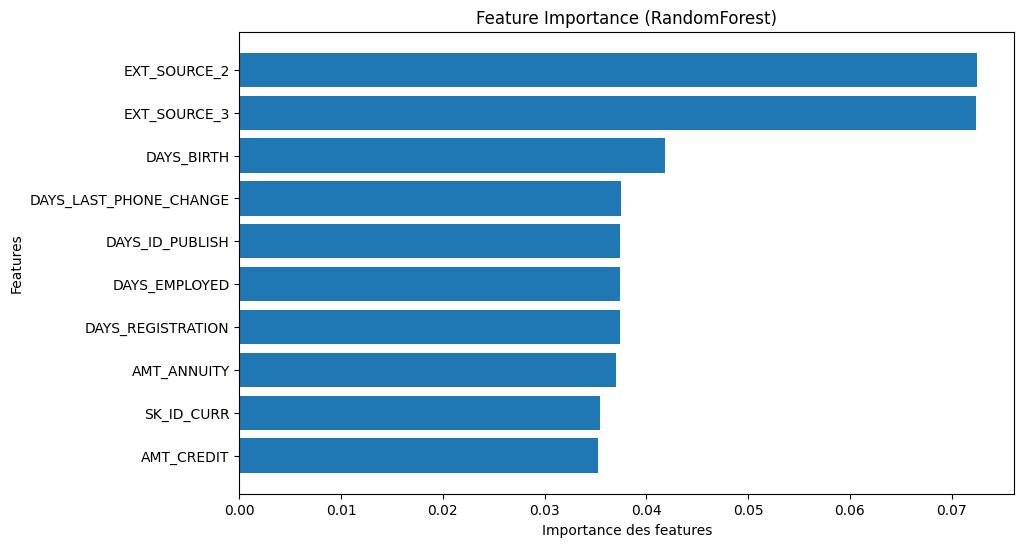

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accéder au modèle RandomForest dans le pipeline et obtenir les importances des features
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Obtenir les noms des features (assumant que X_train est un DataFrame)
feature_names = X_train.columns

# Trier les features par ordre d'importance
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Afficher les importances sous forme de graphique
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:10], sorted_importances[:10])  # Afficher les 10 features les plus importantes
plt.xlabel("Importance des features")
plt.ylabel("Features")
plt.title("Feature Importance (RandomForest)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
!pip install streamlit


2024-11-12 14:25:33.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:33.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:33.692 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:33.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:33.739 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:34.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 14:25:34.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

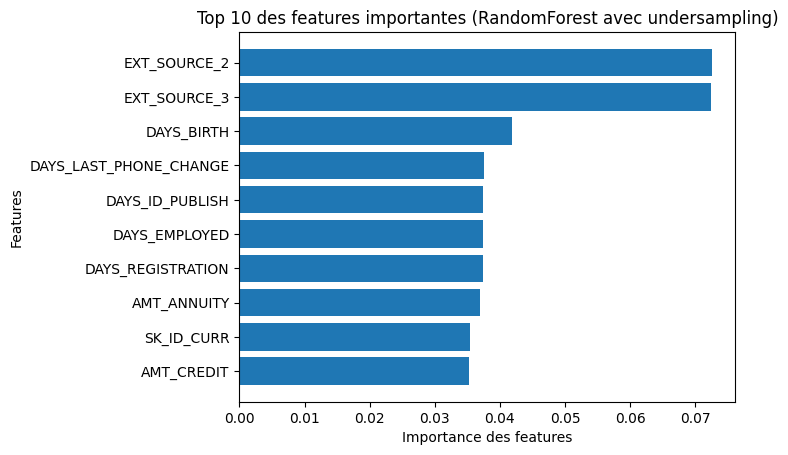

In [ ]:
# dashboard.py

import streamlit as st
import matplotlib.pyplot as plt
import numpy as np

# Titre du tableau de bord
st.title("Tableau de bord des importances des features")

# Calculer les importances des features avec le modèle sous-échantillonné
# Assurer que 'pipeline' est ton modèle avec undersampling et RandomForest
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Obtenir le nom des features (assumant que X_train est un DataFrame)
feature_names = X_train.columns

# Trier les features par importance
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Afficher les 10 features les plus importantes dans Streamlit
st.header("Top 10 des features importantes")

# Afficher le graphique dans Streamlit
fig, ax = plt.subplots()
ax.barh(sorted_feature_names[:10], sorted_importances[:10])
ax.set_xlabel("Importance des features")
ax.set_ylabel("Features")
ax.set_title("Top 10 des features importantes (RandomForest avec undersampling)")
ax.invert_yaxis()
st.pyplot(fig)



In [ ]:
# Écrire le fichier dashboard.py avec le code du tableau de bord Streamlit
with open("dashboard.py", "w") as file:
    file.write("""
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np

# Titre du tableau de bord
st.title("Tableau de bord des importances des features")

# Calculer les importances des features avec le modèle sous-échantillonné
# Assurer que 'pipeline' est ton modèle avec undersampling et RandomForest
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Obtenir le nom des features (assumant que X_train est un DataFrame)
feature_names = X_train.columns

# Trier les features par importance
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Afficher les 10 features les plus importantes dans Streamlit
st.header("Top 10 des features importantes")

# Afficher le graphique dans Streamlit
fig, ax = plt.subplots()
ax.barh(sorted_feature_names[:10], sorted_importances[:10])
ax.set_xlabel("Importance des features")
ax.set_ylabel("Features")
ax.set_title("Top 10 des features importantes (RandomForest avec undersampling)")
ax.invert_yaxis()
st.pyplot(fig)
""")

print("Fichier dashboard.py créé avec succès.")


Fichier dashboard.py créé avec succès.


In [ ]:
!streamlit run dashboard.py --server.port 8501 &





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.244.111:8501

  Stopping...


In [ ]:
# Lancer Streamlit sur le port 8501 en arrière-plan
!streamlit run dashboard.py --server.port 8501 &

# Utiliser ngrok pour exposer le port 8501
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Tableau de bord Streamlit accessible à l'adresse suivante :", public_url)







  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.244.111:8501



In [ ]:
pip install pyngrok


In [ ]:
!pip install fastapi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Installer les dépendances nécessaires
!pip install fastapi uvicorn pyngrok pydantic nest-asyncio

# Importer les bibliothèques nécessaires
from fastapi import FastAPI
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn
import random
import nest_asyncio

# Ajouter votre clé d'authentification ngrok
!ngrok config add-authtoken 2oidFyZwupIzKw3bZkbLdrLyC9t_7kcbkBtd6aKdaea5j9q4D

# Initialiser l'application FastAPI
app = FastAPI()

# Définir le schéma d'entrée : seulement le numéro client
class InputData(BaseModel):
    SK_ID_CURR: int

@app.get("/")
def home():
    return {"message": "Bienvenue sur l'API de prédiction de crédit !"}

@app.post("/predict")
def predict(data: InputData):
    # Utiliser l'identifiant client pour effectuer une prédiction aléatoire
    result = random.choice([0, 1])
    decision = "Crédit accordé" if result == 1 else "Crédit refusé"

    # Retourner le résultat avec un message
    return {
        "SK_ID_CURR": data.SK_ID_CURR,
        "result": result,
        "decision": decision
    }

# Démarrer ngrok pour exposer le port 8000
public_url = ngrok.connect(8000)
print(f"L'API est accessible publiquement à : {public_url}")

# Corriger le problème asyncio avec nest_asyncio
nest_asyncio.apply()

# Lancer Uvicorn pour exécuter FastAPI
uvicorn.run(app, host="0.0.0.0", port=8000)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.9 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


INFO:     Started server process [400]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


L'API est accessible publiquement à : NgrokTunnel: "https://5568-34-142-255-232.ngrok-free.app" -> "http://localhost:8000"
INFO:     194.9.98.101:0 - "GET / HTTP/1.1" 200 OK
INFO:     194.9.98.101:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     194.9.98.101:0 - "GET / HTTP/1.1" 200 OK
INFO:     45.148.110.128:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     45.148.110.128:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     45.148.110.128:0 - "POST /predict HTTP/1.1" 200 OK


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import random

# Initialiser l'application FastAPI
app = FastAPI()

# Liste des features importantes
features = [
    "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH", "DAYS_LAST_PHONE_CHANGE",
    "DAYS_ID_PUBLISH", "DAYS_EMPLOYED", "DAYS_REGISTRATION",
    "AMT_ANNUITY", "SK_ID_CURR", "AMT_CREDIT"
]

# Définir le schéma d'entrée avec Pydantic
class InputData(BaseModel):
    EXT_SOURCE_2: float
    EXT_SOURCE_3: float
    DAYS_BIRTH: int
    DAYS_LAST_PHONE_CHANGE: int
    DAYS_ID_PUBLISH: int
    DAYS_EMPLOYED: int
    DAYS_REGISTRATION: int
    AMT_ANNUITY: float
    SK_ID_CURR: int
    AMT_CREDIT: float

# Route de test pour vérifier l'API
@app.get("/")
def home():
    return {"message": "Bienvenue sur l'API de prédiction de crédit !"}

# Route pour effectuer des prédictions
@app.post("/predict")
def predict(data: InputData):
    # Générer un résultat aléatoire (1 = crédit accordé, 0 = crédit refusé)
    result = random.choice([0, 1])

    # Retourner le résultat avec un message
    decision = "Crédit accordé" if result == 1 else "Crédit refusé"
    return {"result": result, "decision": decision}


In [ ]:
!pip install uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Installer les dépendances nécessaires
!pip install fastapi uvicorn pyngrok pydantic nest-asyncio

# Importer les bibliothèques nécessaires
from fastapi import FastAPI
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn
import random
import nest_asyncio

# Ajouter votre clé d'authentification ngrok
!ngrok config add-authtoken 2oidFyZwupIzKw3bZkbLdrLyC9t_7kcbkBtd6aKdaea5j9q4D

# Initialiser l'application FastAPI
app = FastAPI()

# Définir les features importantes
class InputData(BaseModel):
    EXT_SOURCE_2: float
    EXT_SOURCE_3: float
    DAYS_BIRTH: int
    DAYS_LAST_PHONE_CHANGE: int
    DAYS_ID_PUBLISH: int
    DAYS_EMPLOYED: int
    DAYS_REGISTRATION: int
    AMT_ANNUITY: float
    SK_ID_CURR: int
    AMT_CREDIT: float

@app.get("/")
def home():
    return {"message": "Bienvenue sur l'API de prédiction de crédit !"}

@app.post("/predict")
def predict(data: InputData):
    # Générer un résultat aléatoire (1 = crédit accordé, 0 = crédit refusé)
    result = random.choice([0, 1])
    decision = "Crédit accordé" if result == 1 else "Crédit refusé"
    return {"result": result, "decision": decision}

# Démarrer ngrok pour exposer le port 8000
public_url = ngrok.connect(8000)
print(f"L'API est accessible publiquement à : {public_url}")

# Corriger le problème asyncio avec nest_asyncio
nest_asyncio.apply()

# Lancer Uvicorn pour exécuter FastAPI
uvicorn.run(app, host="0.0.0.0", port=8000)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.2 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


INFO:     Started server process [197]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


L'API est accessible publiquement à : NgrokTunnel: "https://56a7-35-194-83-231.ngrok-free.app" -> "http://localhost:8000"
INFO:     41.83.63.184:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     41.83.63.184:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     41.83.63.184:0 - "POST /predict HTTP/1.1" 200 OK
